<h1>E-commerce customer churn analysis and prediction</h1>
<p>
Background: This project aims to build a classification model to identify customers who are going to churn so that they can approach customer to offer some promos.</p>

<h2>Libraries</h2>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
np.random.seed(42)

<h2>Load dataset</h2>

In [4]:
df = pd.read_excel("data/e-commerce-dataset.xlsx", sheet_name = "E Comm")

<h2>Exploratory data analysis and data cleaning</h2>

<h3>Check for missing values and proportion of missing values</h3>
<p>
Loss in dataset is huge from dropping NA values. Replacement of NA values should be done instead
</p>

In [5]:
print("Number of rows before dropping NA:", df.shape[0])
print("Number of rows after dropping NA:", df.dropna().shape[0])

Number of rows before dropping NA: 5630
Number of rows after dropping NA: 3774


<h3>Summary statistics for dataset</h3>
<p>
Outliers are present
</p>

In [6]:
df.describe()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,52815.500000,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.223030
std,1625.385339,0.374240,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.207036
min,50001.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,52815.500000,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.280000
75%,54222.750000,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.392500
max,55630.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,324.990000


<h3>Check for data type for each column</h3>
<p>There are columns in the incorrect data type and categorical variables are present. To perform one-hot encoding on categorical variables</p>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

<h3>Check for number of unique values in each column</h3>

In [8]:
df.nunique()

CustomerID                     5630
Churn                             2
Tenure                           36
PreferredLoginDevice              3
CityTier                          3
WarehouseToHome                  34
PreferredPaymentMode              7
Gender                            2
HourSpendOnApp                    6
NumberOfDeviceRegistered          6
PreferedOrderCat                  6
SatisfactionScore                 5
MaritalStatus                     3
NumberOfAddress                  15
Complain                          2
OrderAmountHikeFromlastYear      16
CouponUsed                       17
OrderCount                       16
DaySinceLastOrder                22
CashbackAmount                 2586
dtype: int64

<h3>Check for duplicated rows</h3>

In [9]:
print("Number of duplicated rows:", df.duplicated().sum())

Number of duplicated rows: 0


<h3>Functions for exploratory data analysis</h3>

In [50]:
def histogram_analysis(df, col, bin_interval, bin_xticklabels):
    bin_arr, bins = pd.cut(df[col], 
                                 bins = bin_interval, 
                                 retbins = True, 
                                 ordered = True)
    fig1 = sns.histplot(df, x = col, bins = bins, stat = 'proportion')
    fig1.set_xticks(bin_xticklabels)
    fig1.margins(x = 0)
    fig1.set_title(f'Distribution of {col}')
    fig1.figure.set_figwidth(10)

    fig2 = sns.FacetGrid(df, row = 'Churn')
    fig2 = fig2.map(sns.histplot, col, bins = bins, stat = 'proportion')
    fig2.figure.set_figwidth(10)
    fig2.figure.set_figheight(8)
    for ax in fig2.axes.flat:
        ax.set_xticks(bin_xticklabels)
        ax.set_xlabel('')
        ax.set_ylabel('Proportion', fontsize = 20)
        ax.tick_params(labelbottom = True, labelsize = 16)
        ax.set_title(f'Distribution of {col} for {ax.get_title()}', fontsize = 20)
        ax.margins(x = 0)
    plt.tight_layout()
    plt.show()

def countplot_analysis(df, col):
    fig1 = sns.countplot(df, 
        x = col, 
        order = df[col].value_counts().index,
        stat = 'proportion')
    fig1.set_title(f'Proportion of {col}')
    fig1.figure.set_figwidth(10)
    fig1.bar_label(fig1.containers[0], fmt = '%.3f')

    fig2 = sns.FacetGrid(df, row = 'Churn')
    fig2 = fig2.map(sns.countplot, 
        col,
        stat = 'proportion',
        order = df[col].value_counts().index)
    fig2.figure.set_figwidth(10)
    fig2.figure.set_figheight(8)
    for ax in fig2.axes.flat:
        ax.tick_params(labelbottom = True)
        ax.set_title(f"Proportion of {col} for {ax.get_title()}")
        ax.bar_label(ax.containers[0], fmt = '%.3f')
    plt.tight_layout()
    plt.show()   

<h3>Analysing value distribution for each column

<p>Disproportionate dataset which is expected for a classification problem</p>

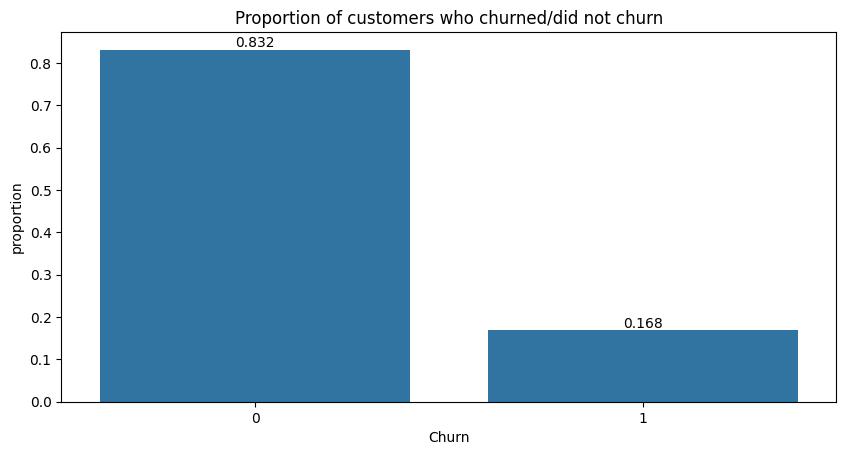

In [51]:
churn_fig1 = sns.countplot(df, x = 'Churn', stat = 'proportion')
churn_fig1.bar_label(container = churn_fig1.containers[0], fmt = '%.3f')
churn_fig1.figure.set_figwidth(10)
plt.title('Proportion of customers who churned/did not churn')
plt.show()

Outliers come from customer who did not churn. To drop outliers (tenure >= 50)

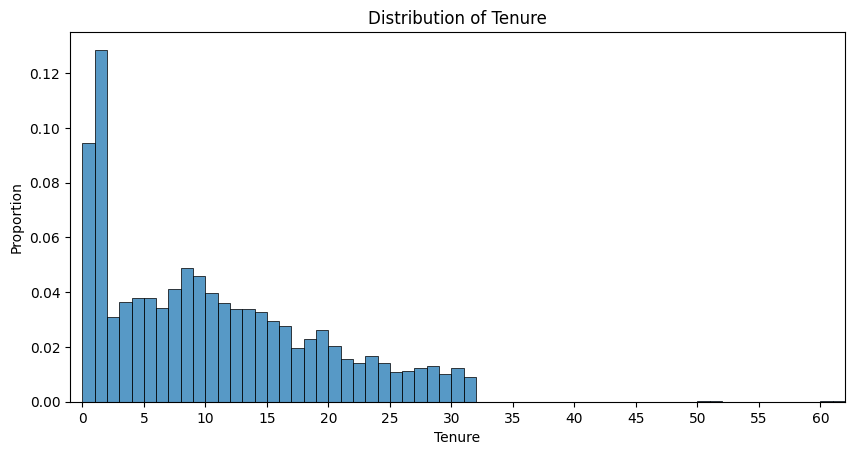

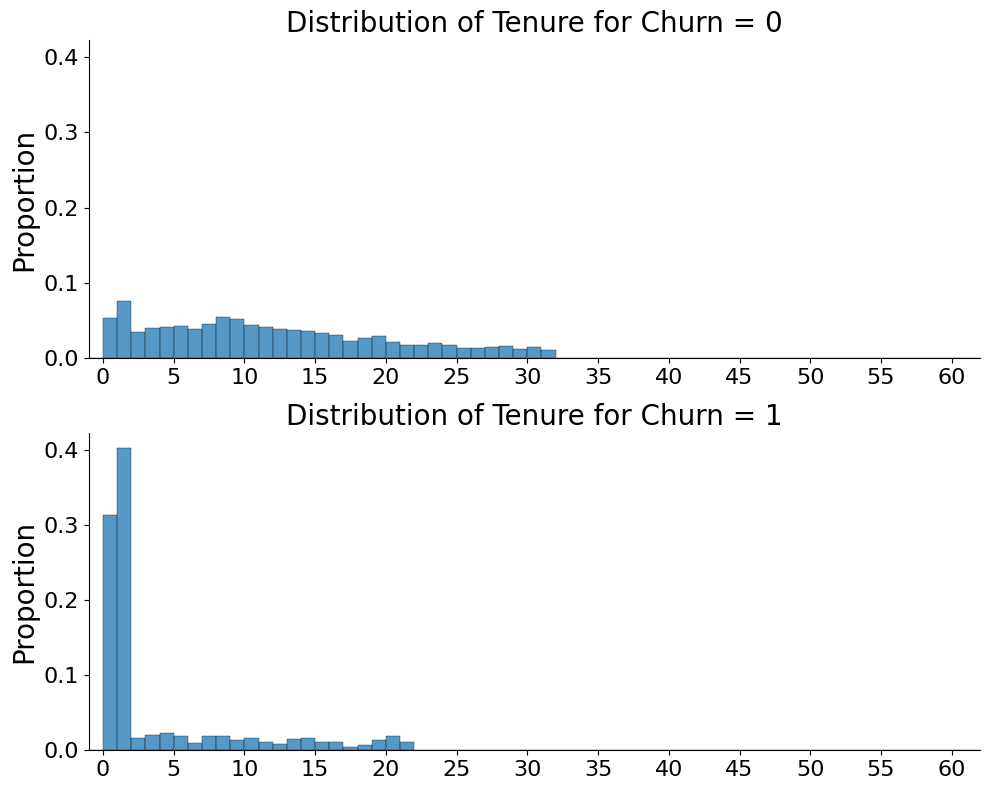

In [52]:
histogram_analysis(df, 
                   'Tenure', 
                   range(int(df['Tenure'].min()) - 1, int(df['Tenure'].max()) + 2), 
                   range(int(df['Tenure'].min()), int(df['Tenure'].max()) + 1, 5)
                   )   

<p>We see a vastly different distribution of values between customers who churned and did not churn. Data cleaning required for PreferredLoginDevice (Mobile Phone and Phone) refer to the same thing.</p>

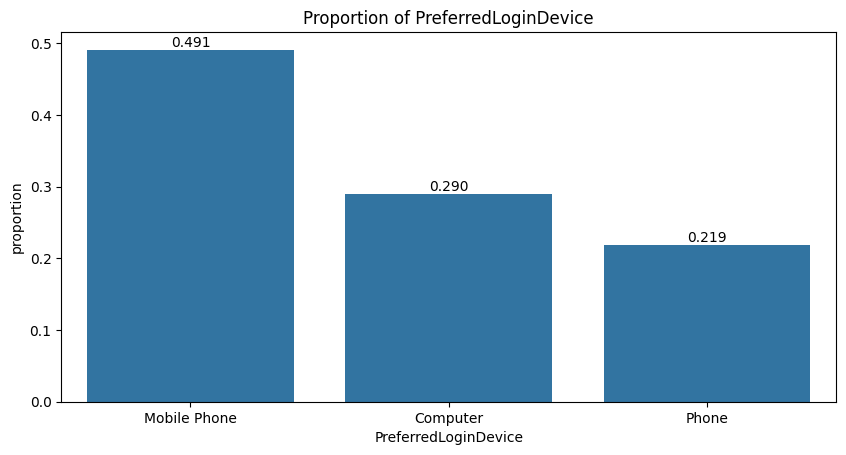

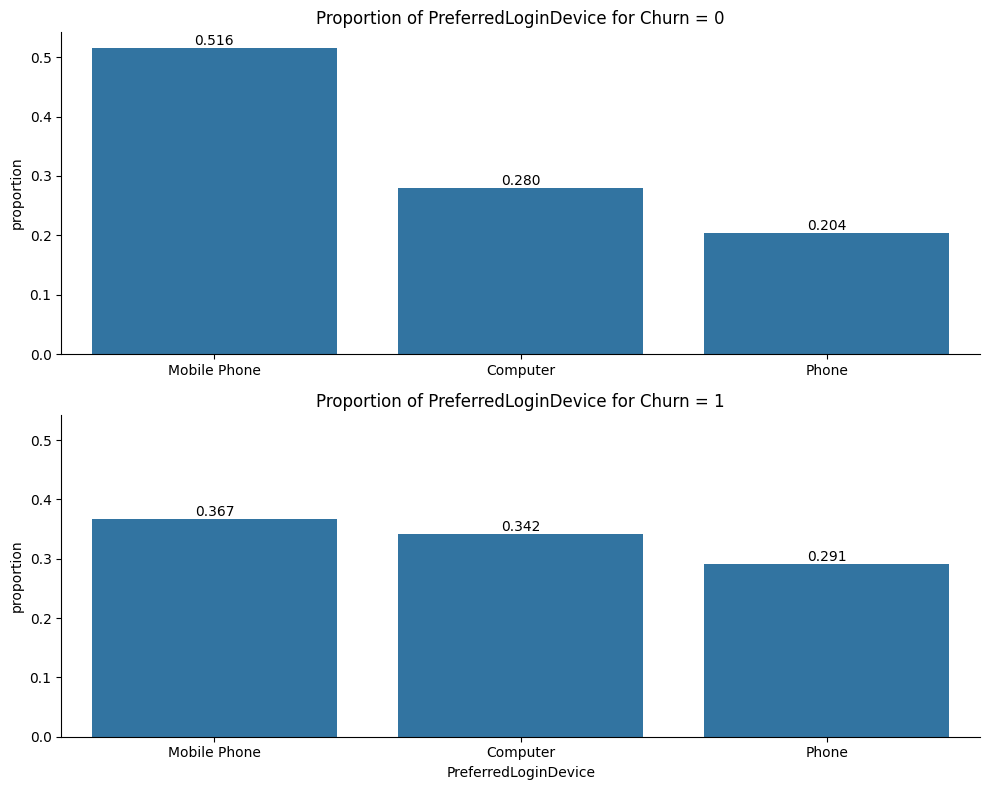

In [54]:
countplot_analysis(df, 'PreferredLoginDevice')

Similar proportions between customers who churned and did not churn

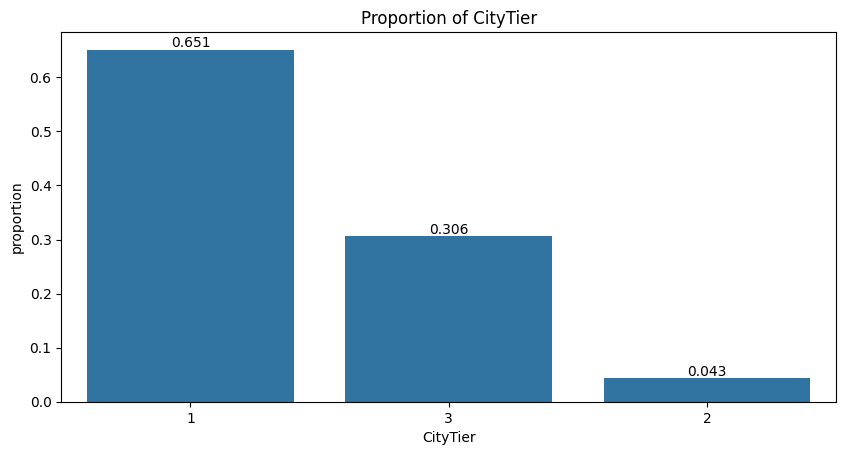

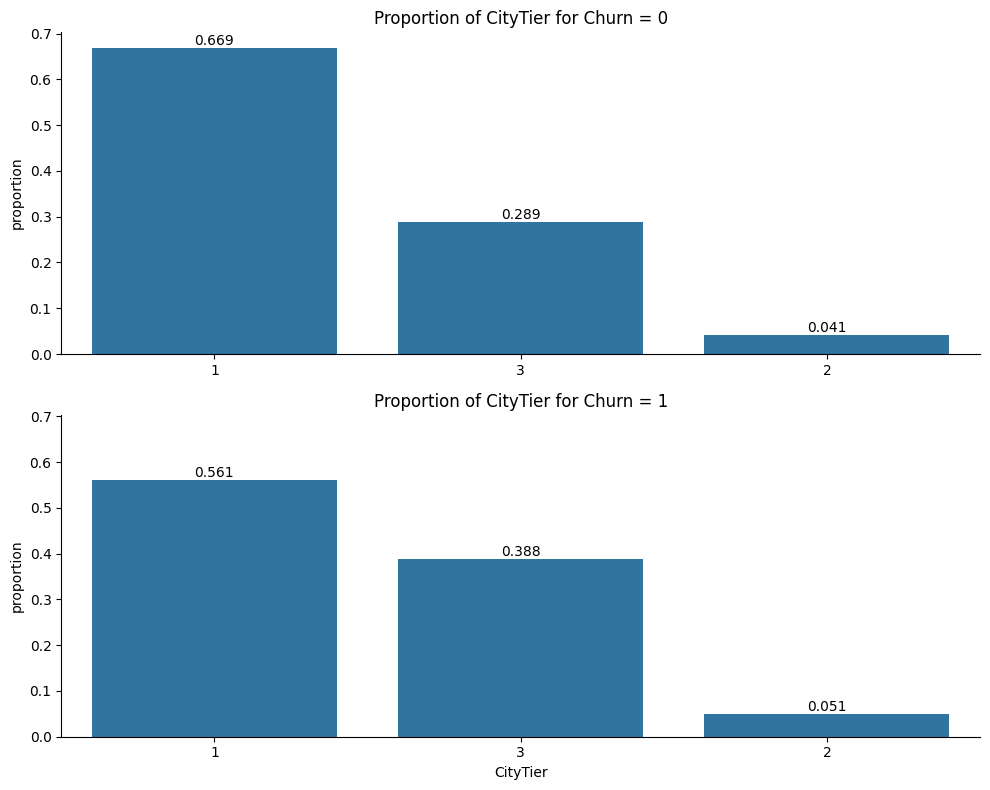

In [55]:
countplot_analysis(df, 'CityTier')

Outliers exist for WarehouseToHome for customers who did not churn (WarehouseToHome > 125). However, general distribution seem very consistent for customers who churned and did not churn.

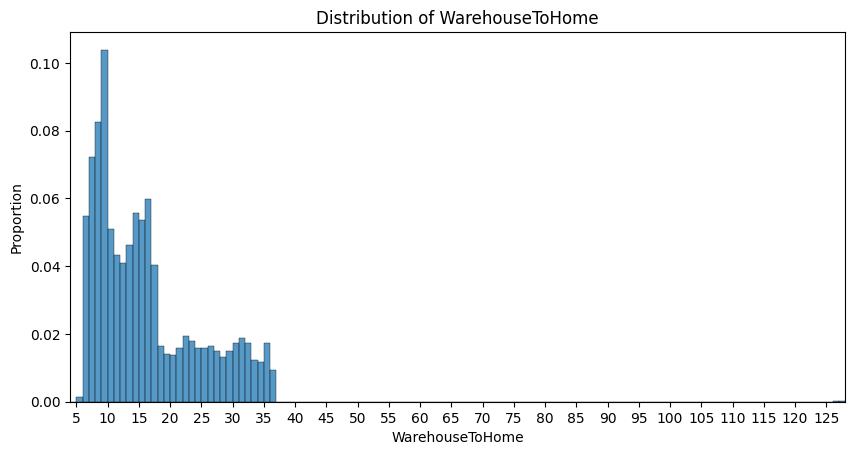

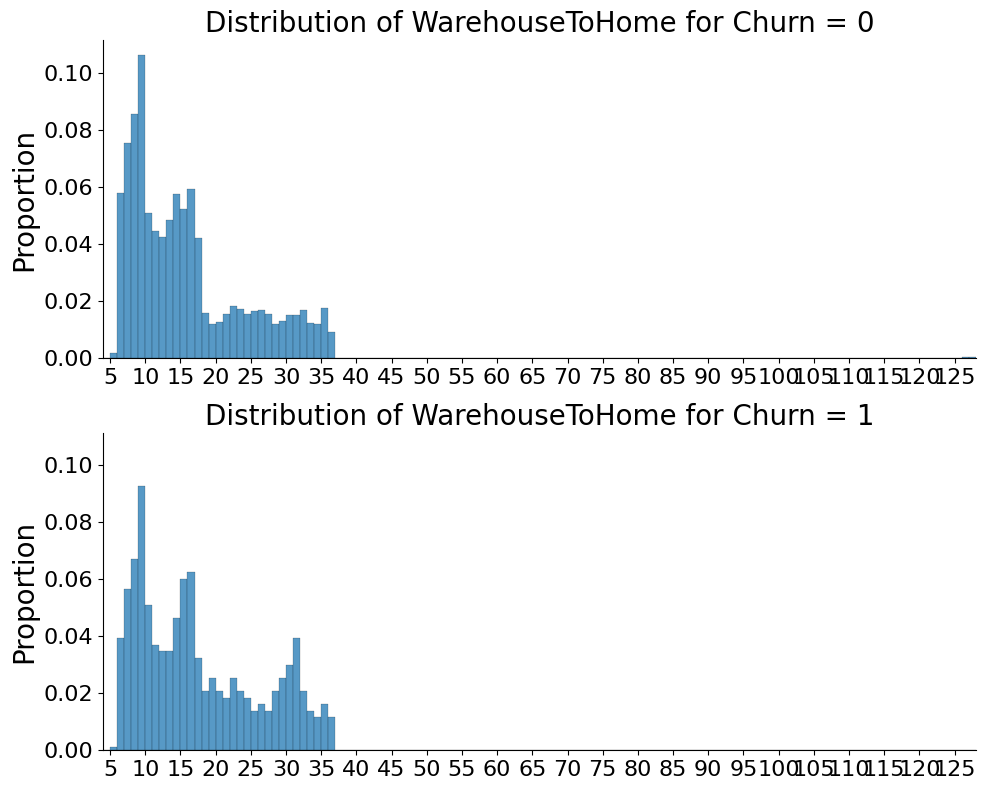

In [56]:
histogram_analysis(df, 
                   'WarehouseToHome',
                    range(int(df['WarehouseToHome'].min()) - 1, int(df['WarehouseToHome'].max()) + 2), 
                   range(int(df['WarehouseToHome'].min()), int(df['WarehouseToHome'].max()) + 1, 5)
)

Consider converting this column into a binary variable (Online vs f2f payment). Also, there are different names for the same thing (COD and Cash on Delivery)

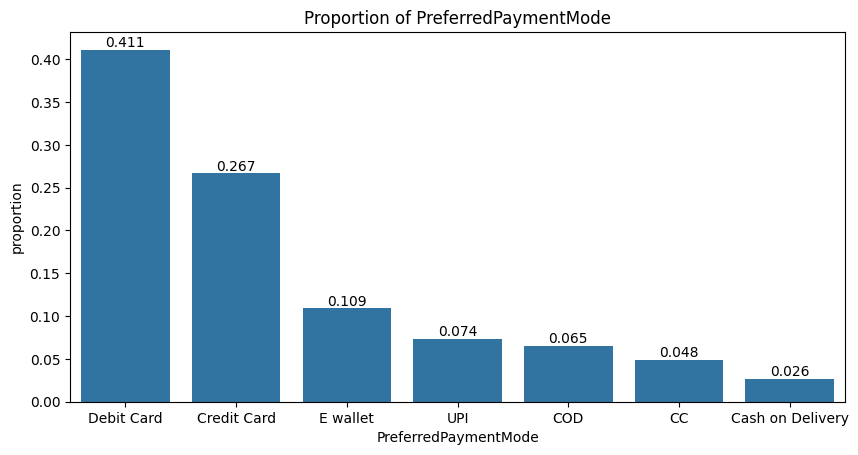

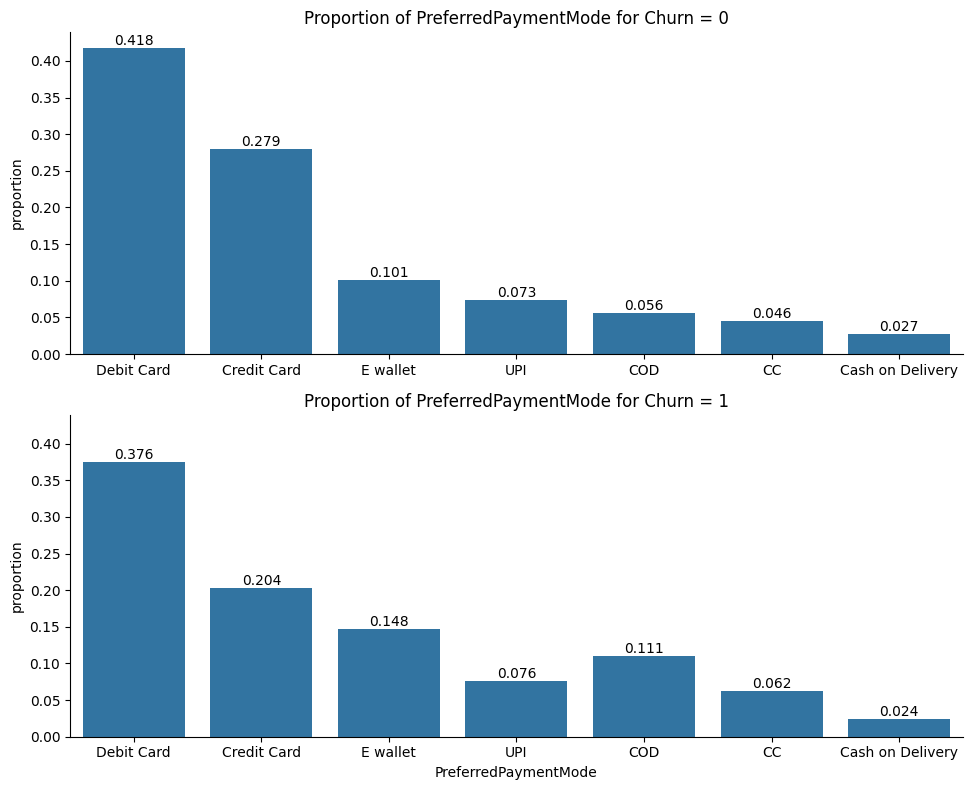

In [57]:
countplot_analysis(df, 'PreferredPaymentMode')

Nothing too special for gender

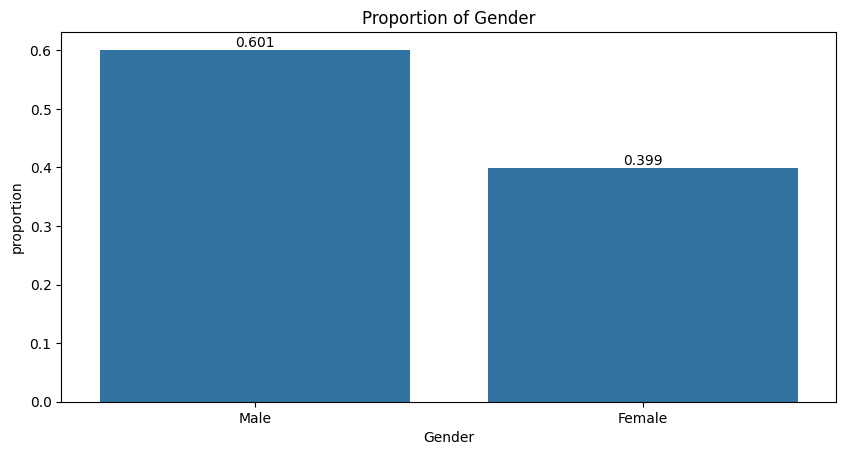

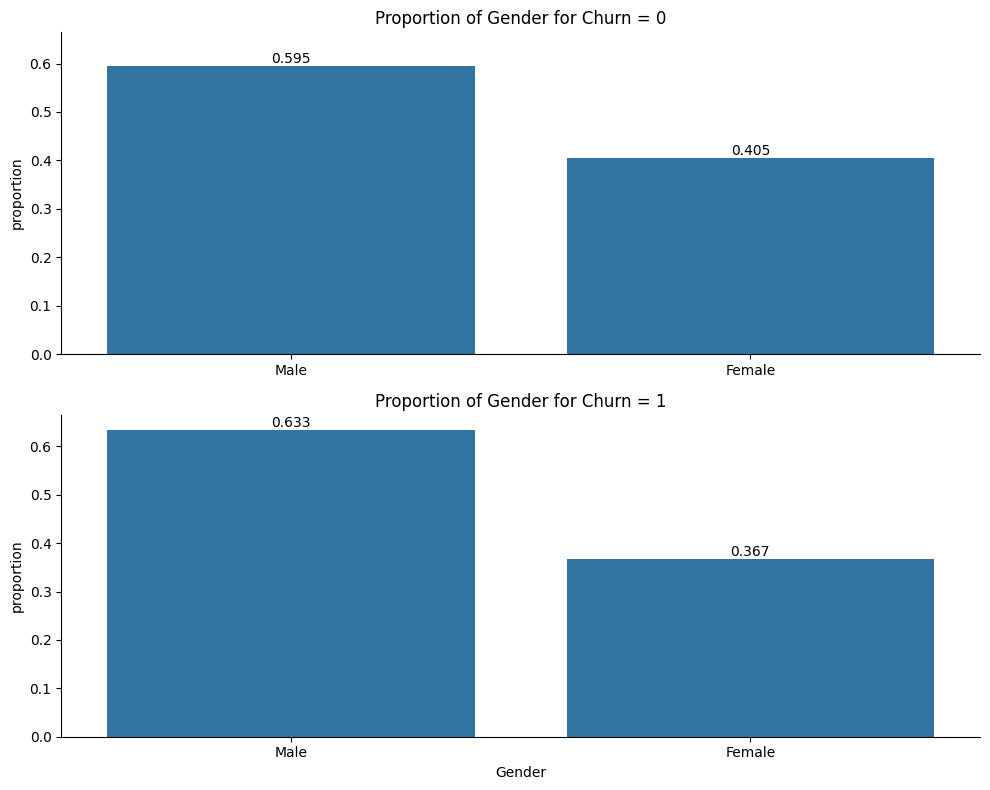

In [58]:
countplot_analysis(df, 'Gender')

Consider switching to binary variable

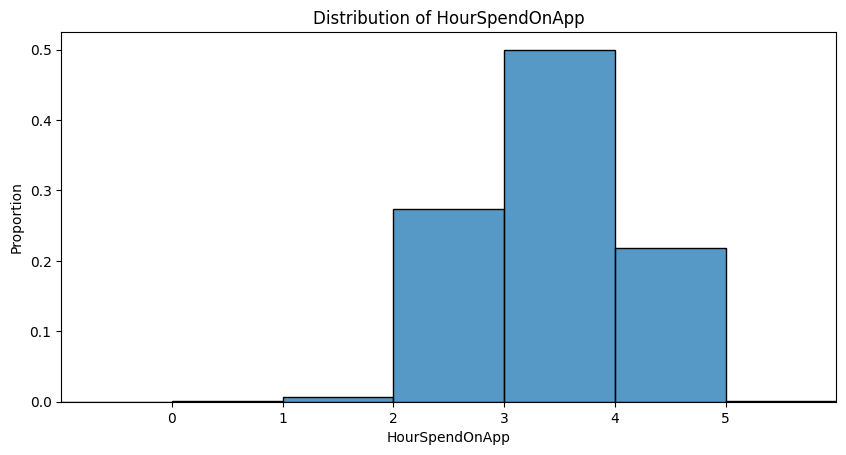

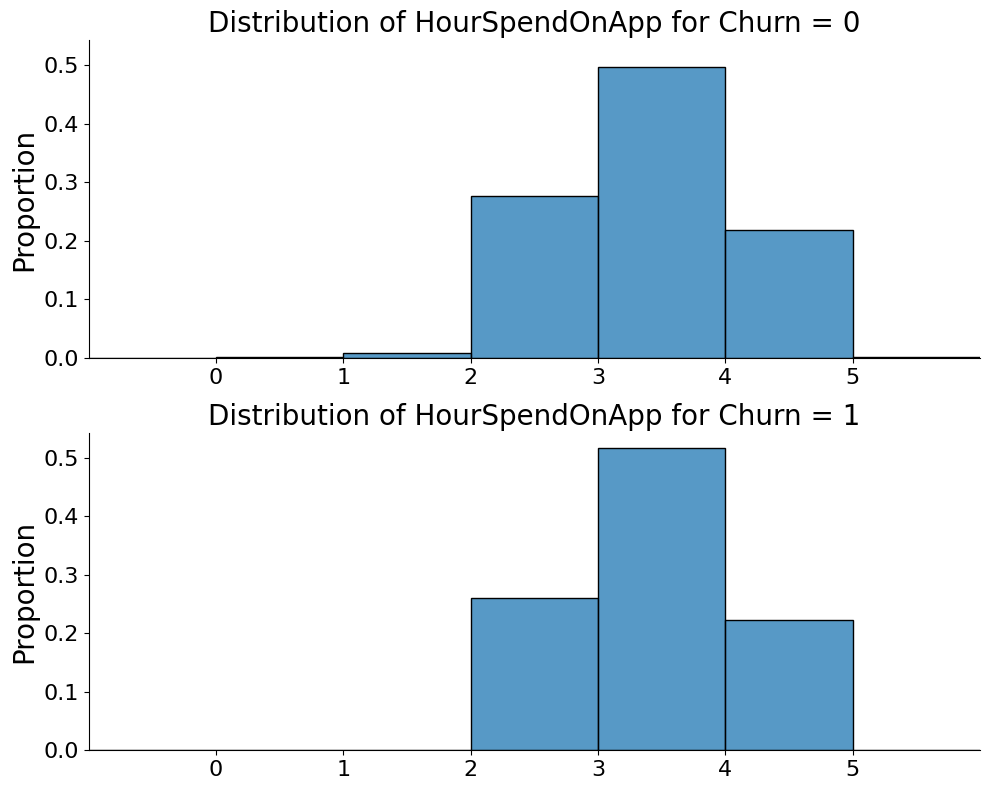

In [59]:
histogram_analysis(df, 
                   'HourSpendOnApp',
                    range(int(df['HourSpendOnApp'].min()) - 1, int(df['HourSpendOnApp'].max()) + 2), 
                   range(int(df['HourSpendOnApp'].min()), int(df['HourSpendOnApp'].max()) + 1)
)

Consider switching to binary variable

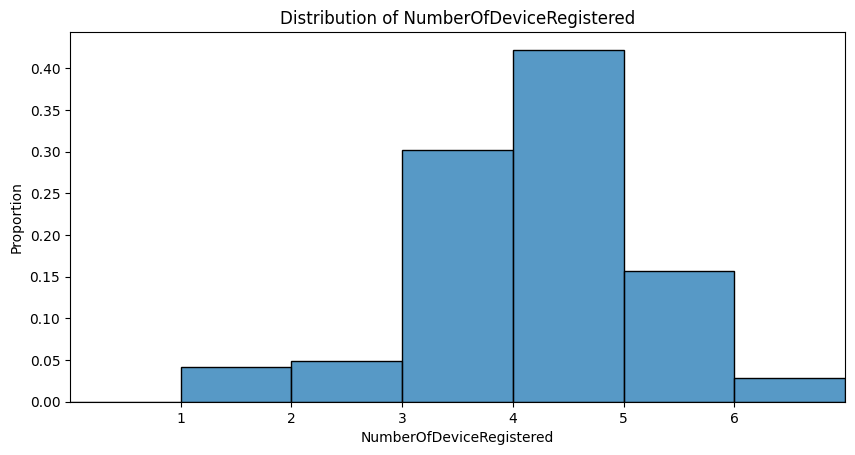

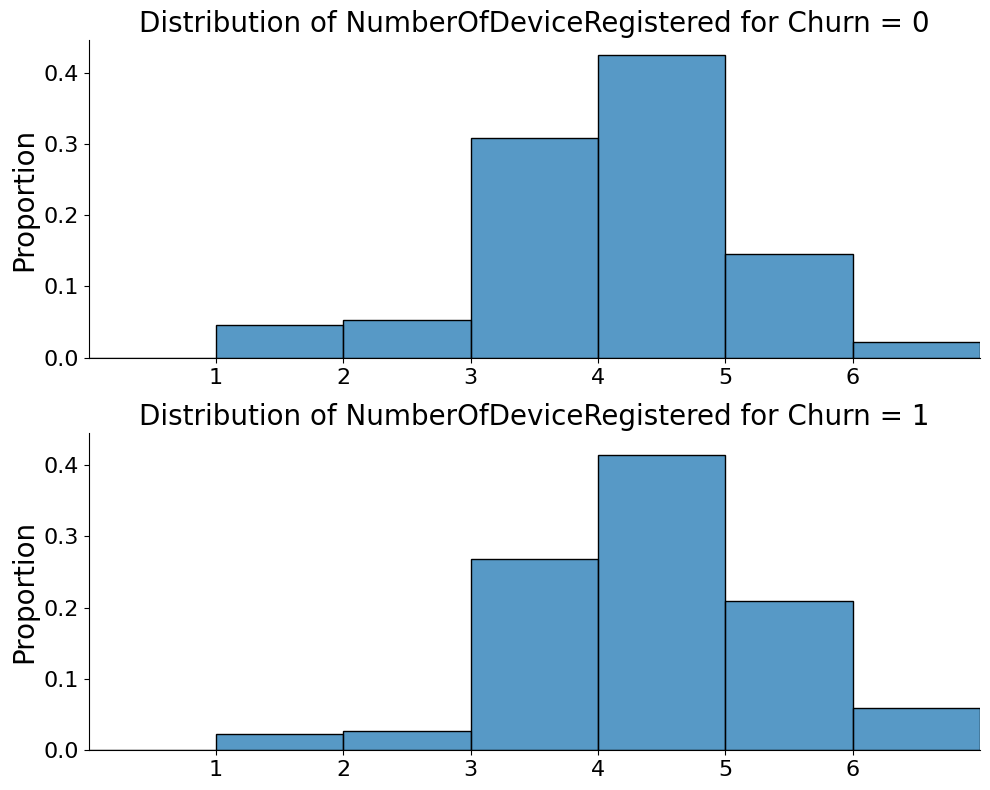

In [60]:
histogram_analysis(df, 
                   'NumberOfDeviceRegistered',
                    range(int(df['NumberOfDeviceRegistered'].min()) - 1, int(df['NumberOfDeviceRegistered'].max()) + 2), 
                   range(int(df['NumberOfDeviceRegistered'].min()), int(df['NumberOfDeviceRegistered'].max()) + 1)
) 

Mobile and Mobile Phone are the same thing. To combine

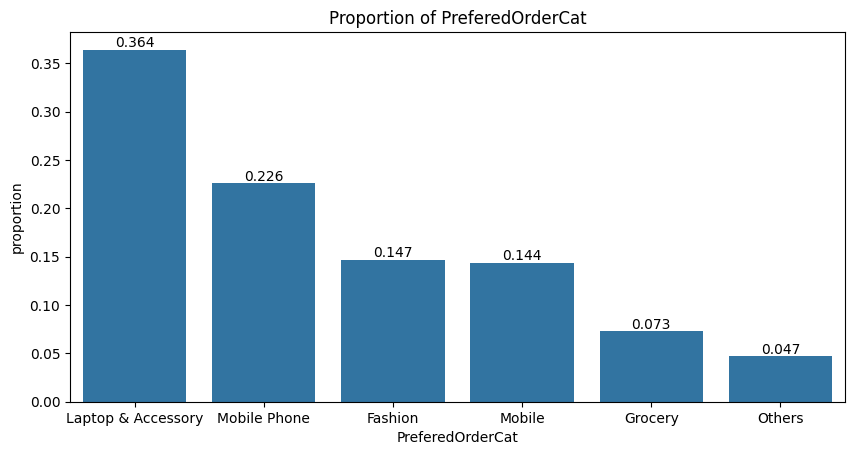

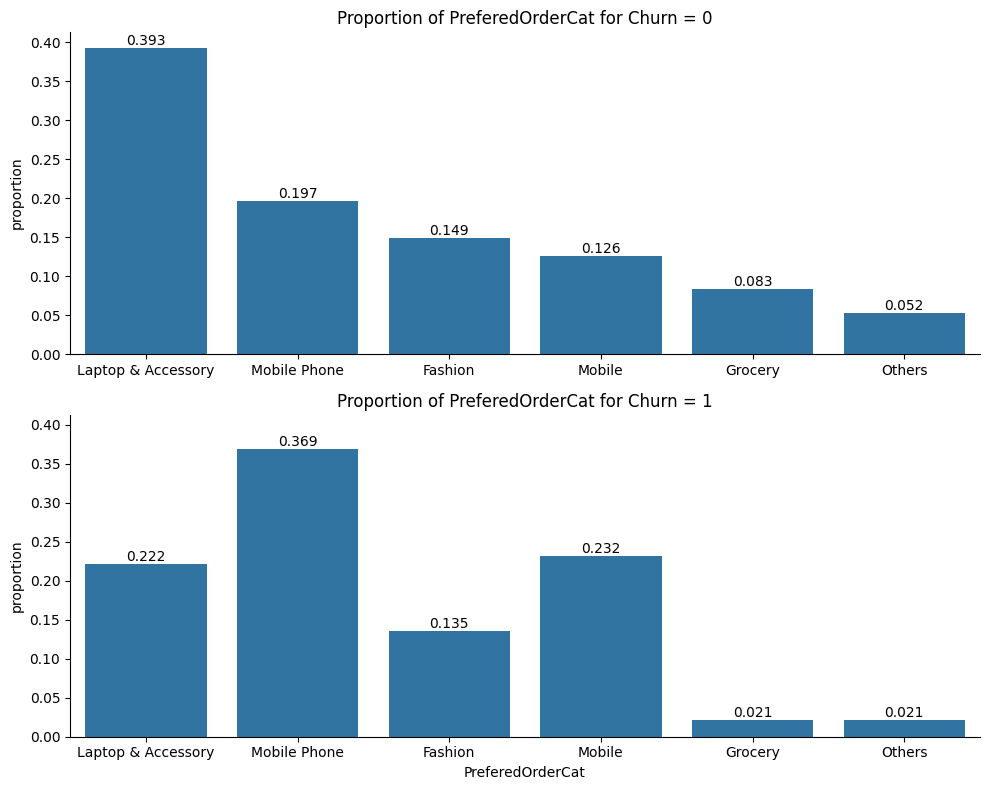

In [61]:
countplot_analysis(df, 'PreferedOrderCat')

Consider converting it into binary variable

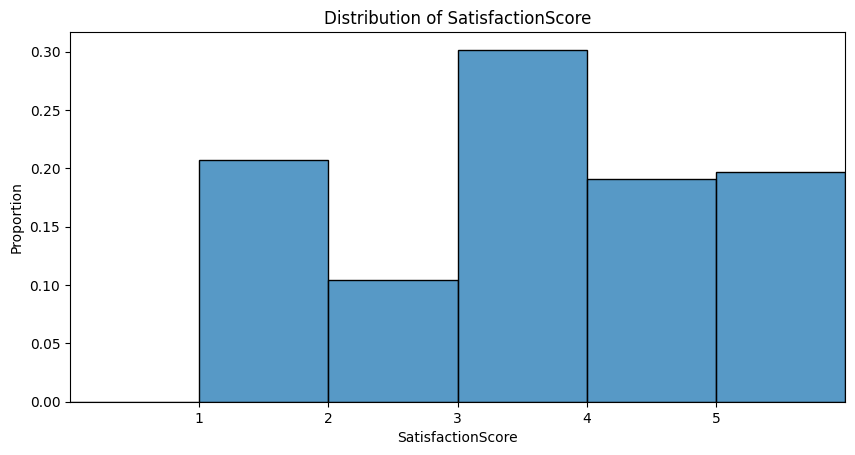

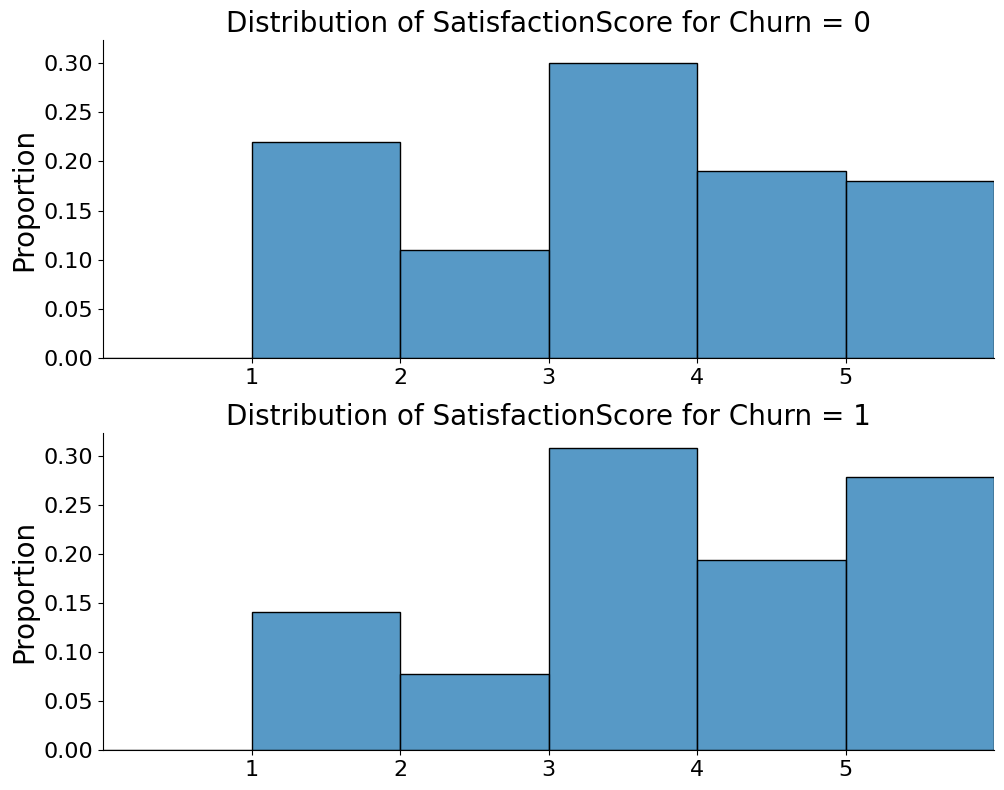

In [62]:
histogram_analysis(df, 
                   'SatisfactionScore',
                    range(int(df['SatisfactionScore'].min()) - 1, int(df['SatisfactionScore'].max()) + 2), 
                   range(int(df['SatisfactionScore'].min()), int(df['SatisfactionScore'].max()) + 1)
)

Interesting difference in distribution

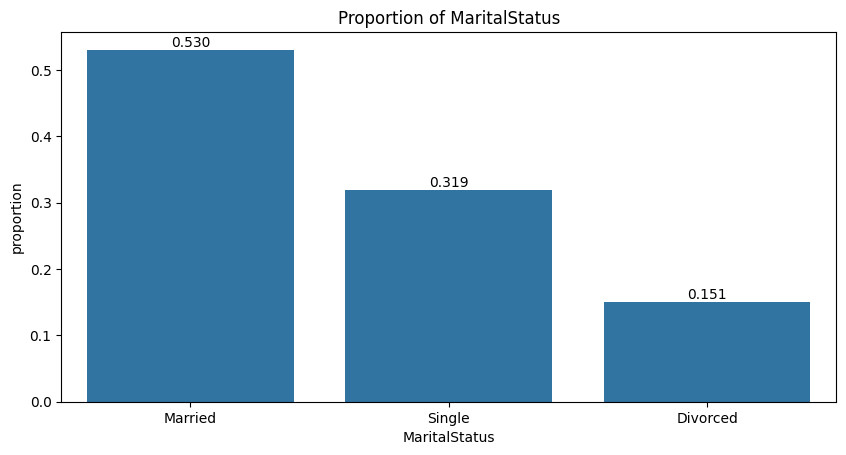

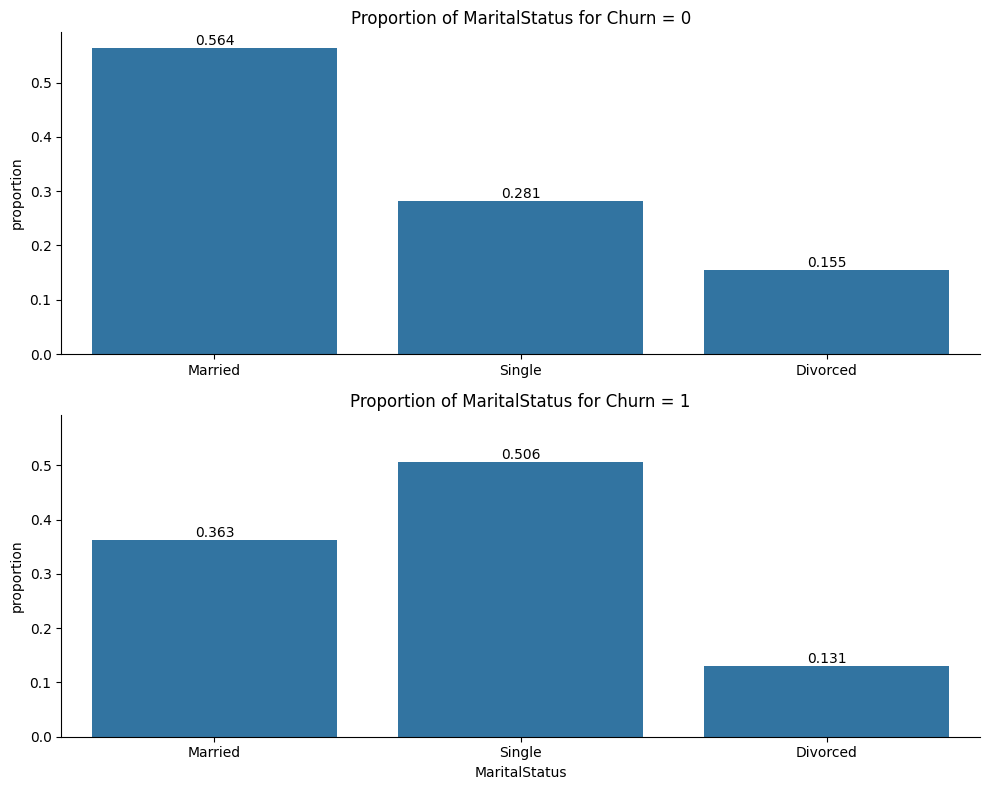

In [63]:
countplot_analysis(df, 'MaritalStatus')

Consider binning the values

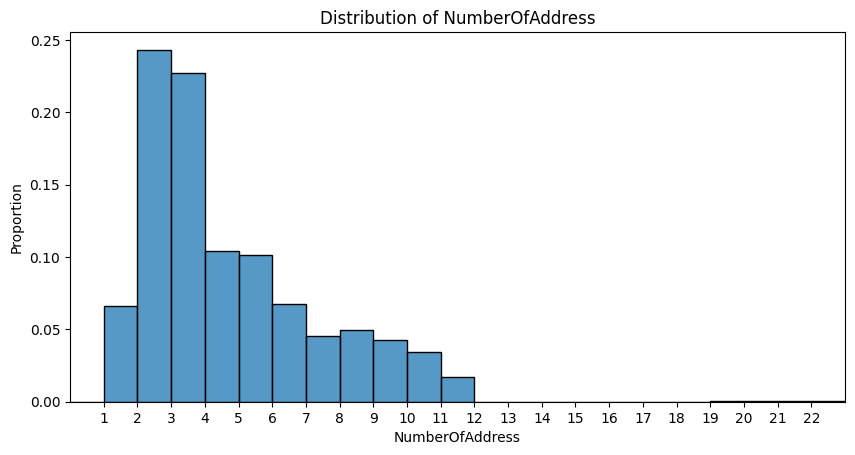

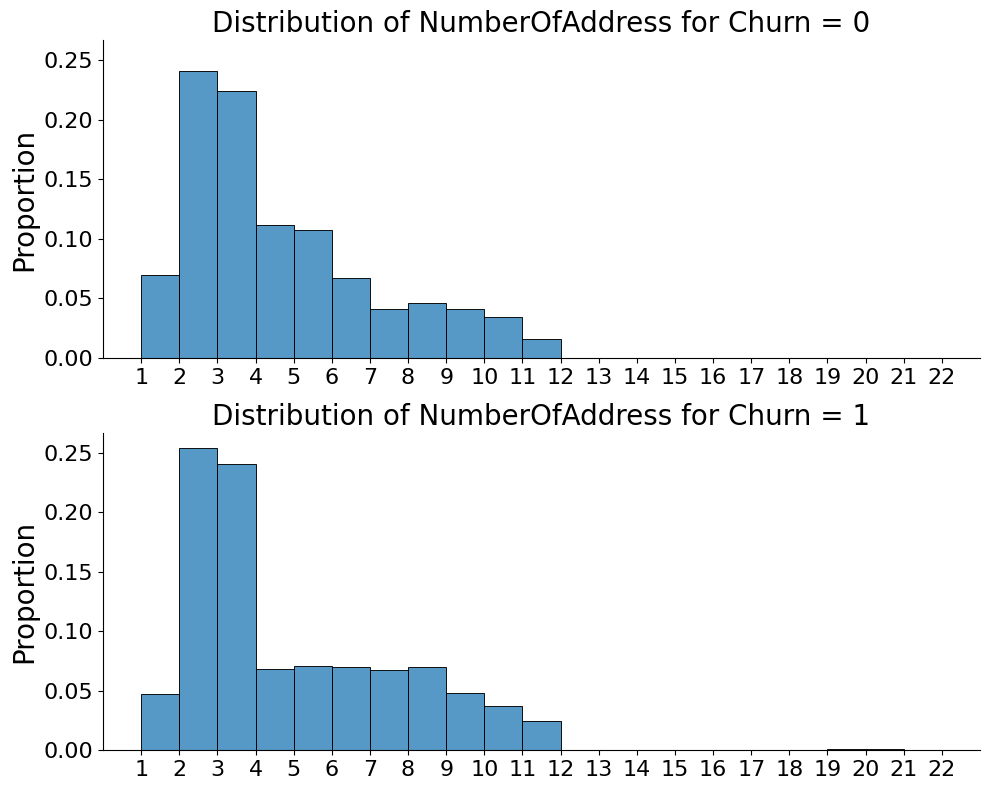

In [64]:
histogram_analysis(df, 
                   'NumberOfAddress',
                    range(int(df['NumberOfAddress'].min()) - 1, int(df['NumberOfAddress'].max()) + 2), 
                   range(int(df['NumberOfAddress'].min()), int(df['NumberOfAddress'].max()) + 1)
)

Useful indicator

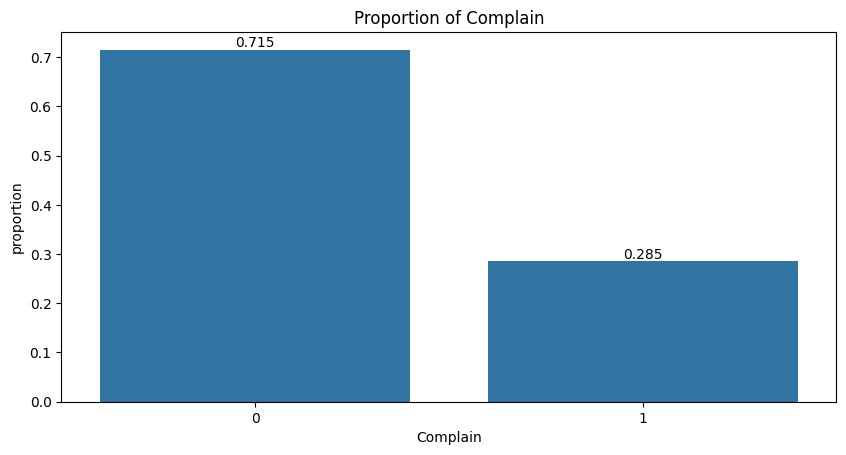

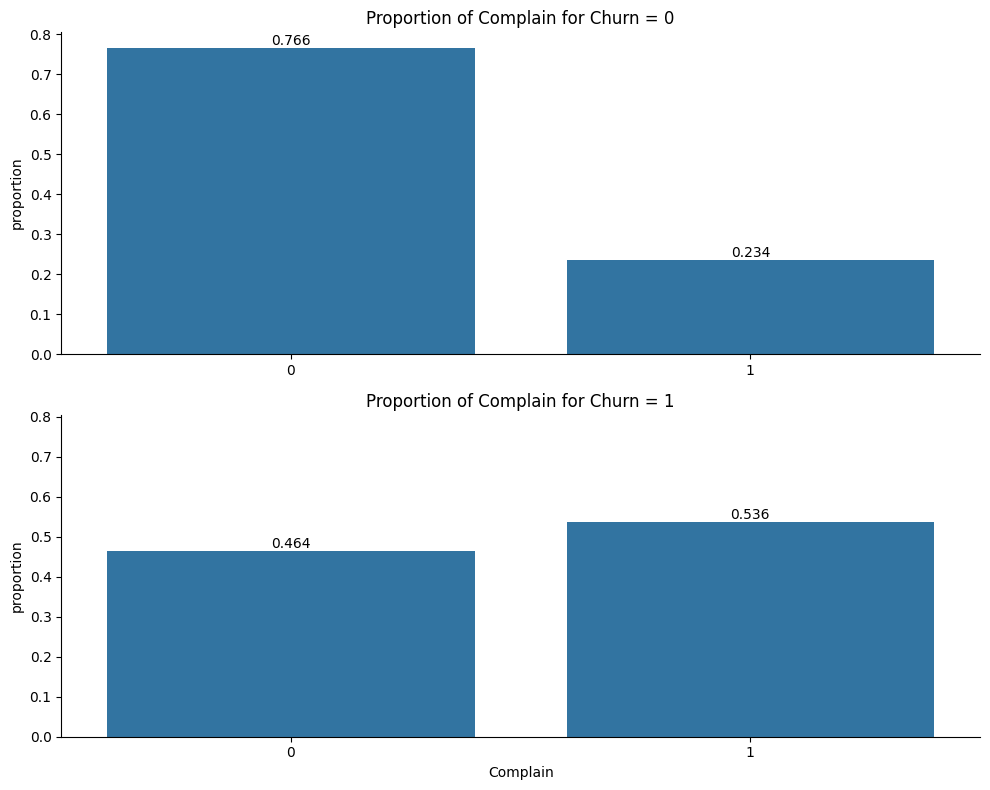

In [66]:
countplot_analysis(df, 'Complain')

Consider binning the values. Does not seem very useful

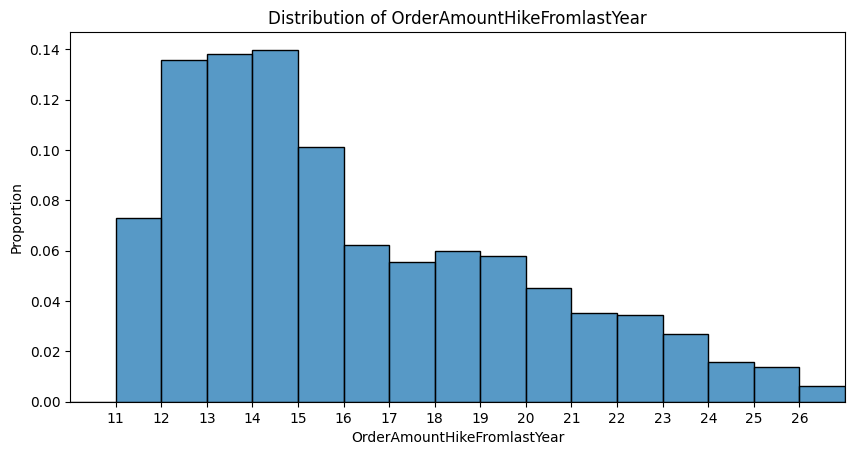

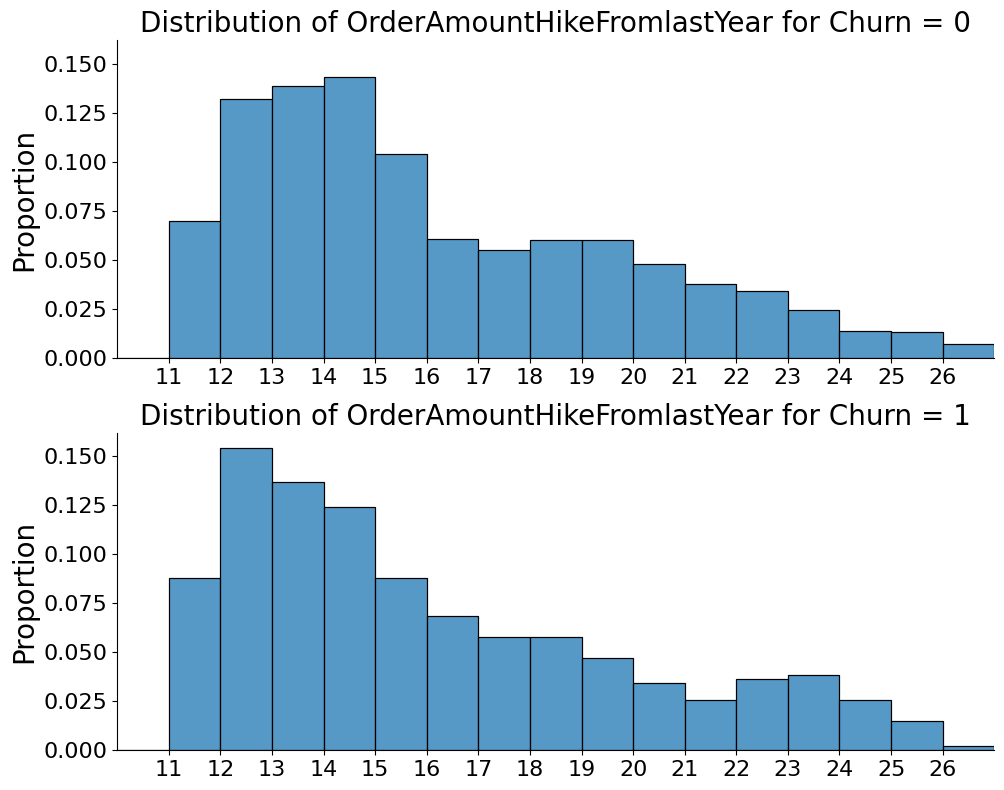

In [67]:
histogram_analysis(df, 
                   'OrderAmountHikeFromlastYear',
                    range(int(df['OrderAmountHikeFromlastYear'].min()) - 1, int(df['OrderAmountHikeFromlastYear'].max()) + 2), 
                   range(int(df['OrderAmountHikeFromlastYear'].min()), int(df['OrderAmountHikeFromlastYear'].max()) + 1)
) 


Very similar distributions for churn and did not churn. May not be a meaningful feature

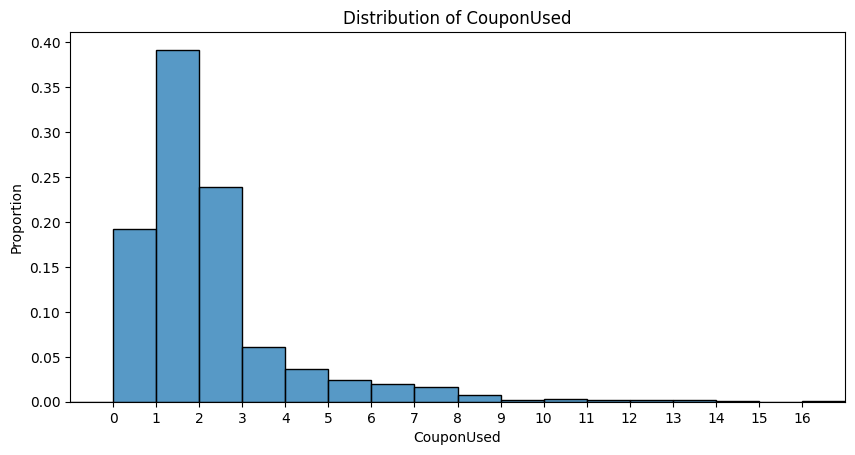

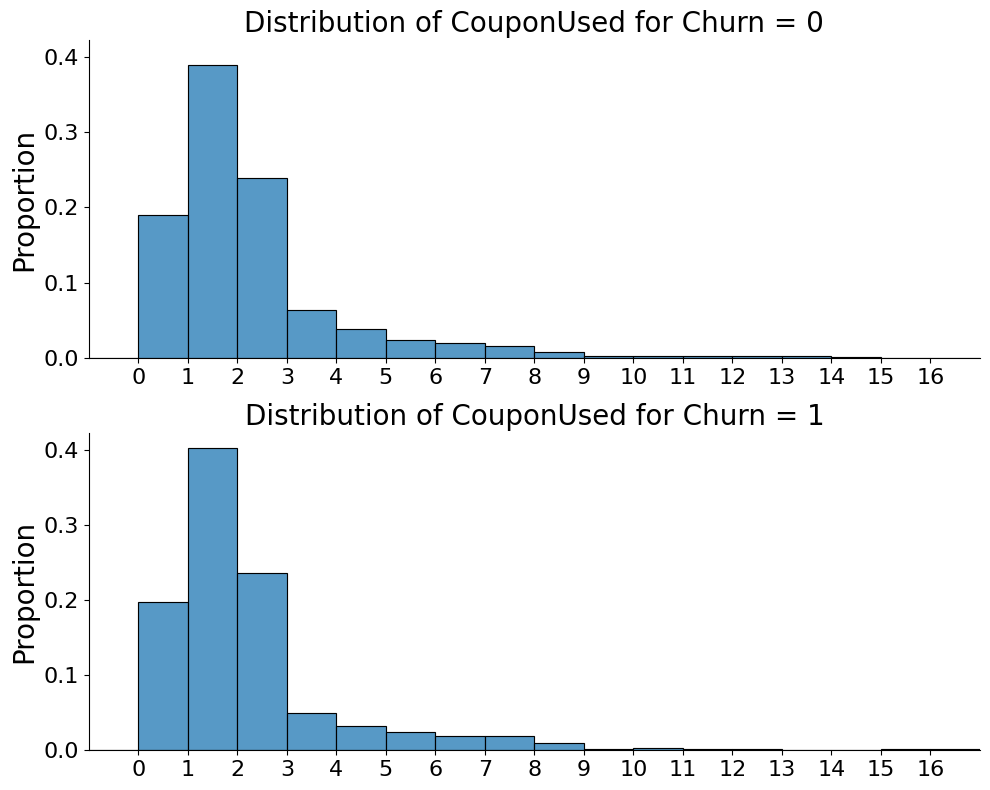

In [68]:
histogram_analysis(df, 
                   'CouponUsed',
                    range(int(df['CouponUsed'].min()) - 1, int(df['CouponUsed'].max()) + 2), 
                   range(int(df['CouponUsed'].min()), int(df['CouponUsed'].max()) + 1)
)

Very similar distributions for churn and did not churn. May not be a meaningful feature

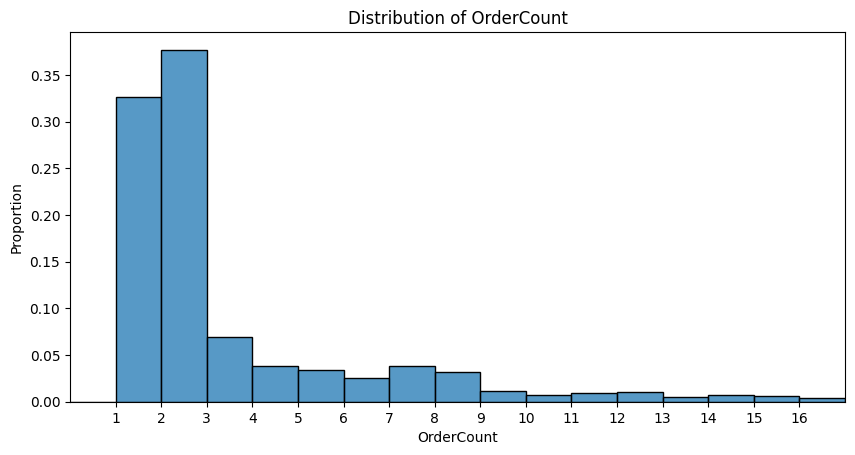

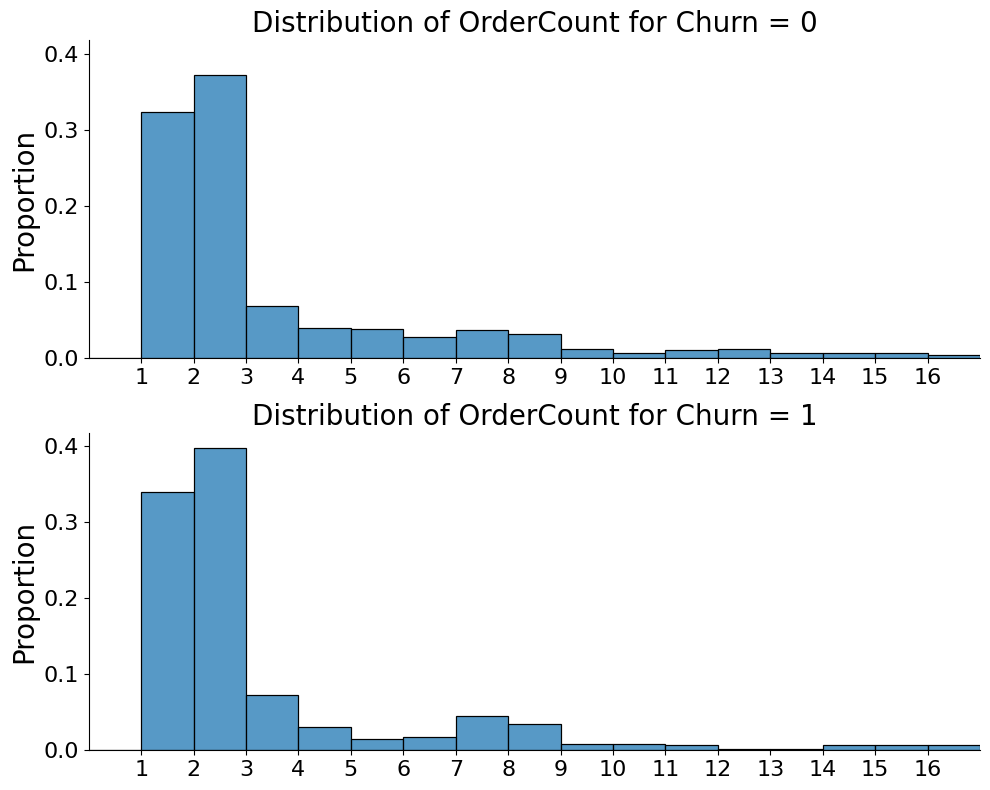

In [69]:
histogram_analysis(df, 
                   'OrderCount',
                    range(int(df['OrderCount'].min()) - 1, int(df['OrderCount'].max()) + 2), 
                   range(int(df['OrderCount'].min()), int(df['OrderCount'].max()) + 1)
)

Consider binning the values

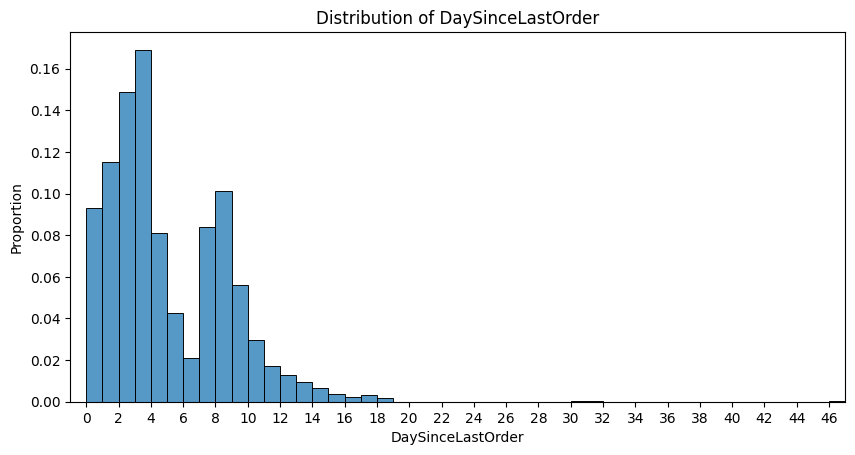

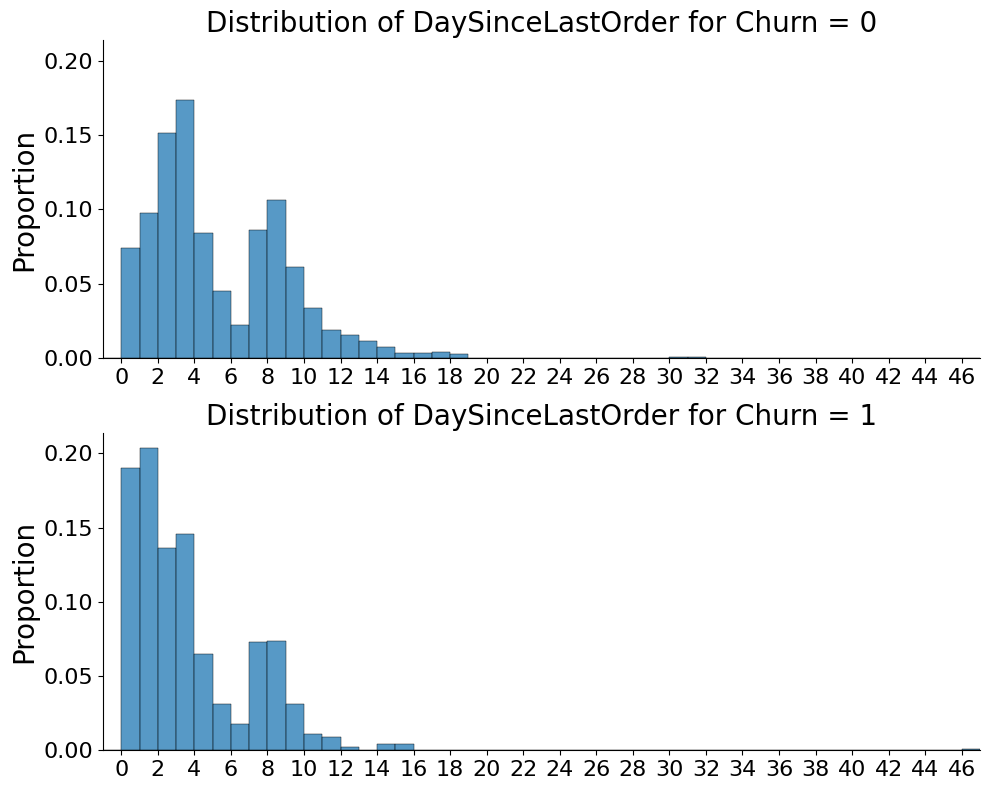

In [71]:
histogram_analysis(df, 
                   'DaySinceLastOrder',
                    range(int(df['DaySinceLastOrder'].min()) - 1, int(df['DaySinceLastOrder'].max()) + 2), 
                   range(int(df['DaySinceLastOrder'].min()), int(df['DaySinceLastOrder'].max()) + 1, 2)
)

Seems useful, those who churned have very low cashbacks

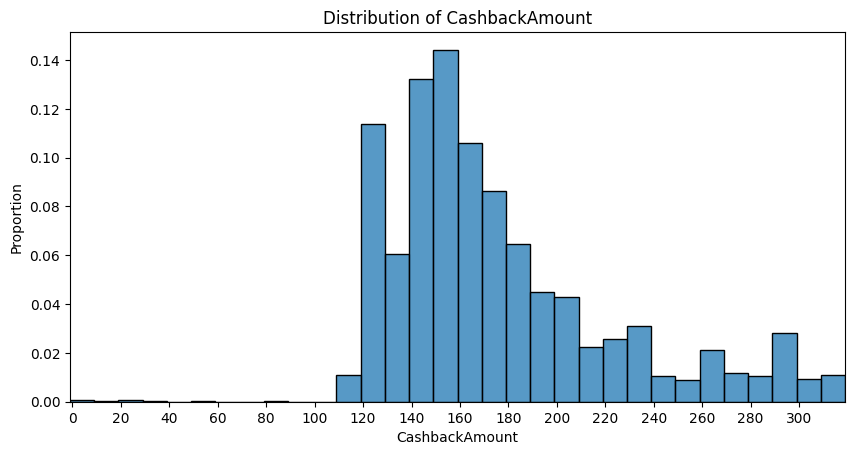

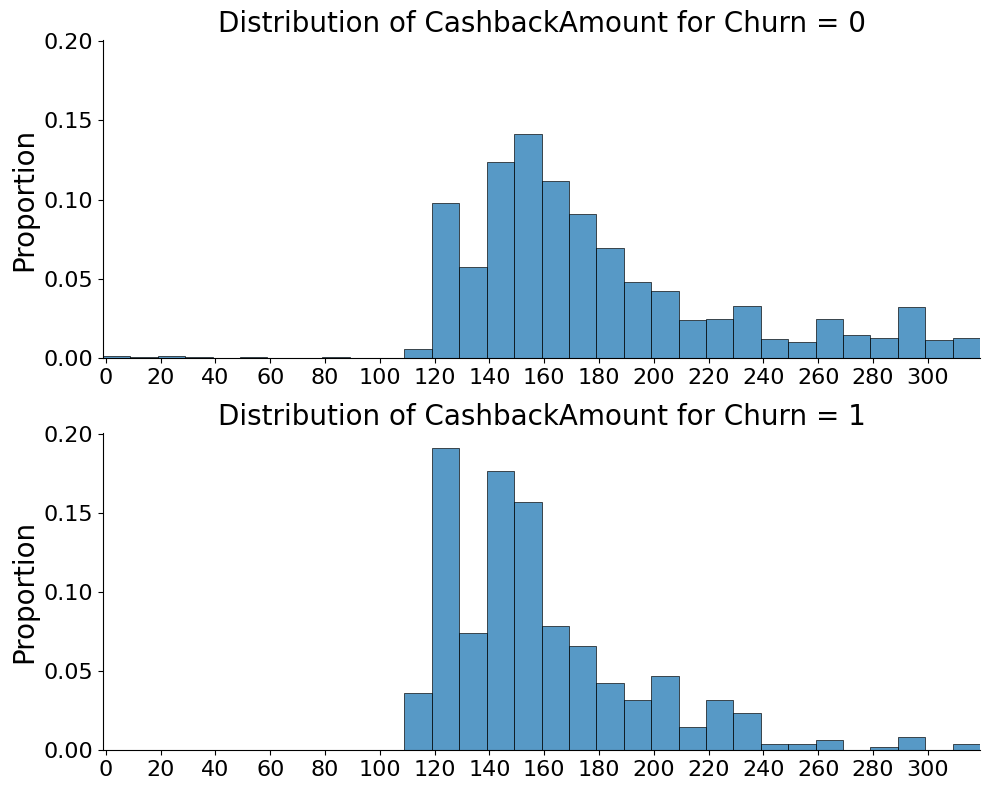

In [72]:
histogram_analysis(df, 
                   'CashbackAmount',
                    range(int(df['CashbackAmount'].min()) - 1, int(df['CashbackAmount'].max()) + 2, 10), 
                   range(int(df['CashbackAmount'].min()), int(df['CashbackAmount'].max()) + 1, 20)
)

<h3>Cleaning data for each column</h3>
<p>Feature engineering is not done here, just replacing NA values, removing outliers and renaming categories that refer to the same thing</p>

In [30]:
'''
Replace values with a random number generator 
given estimated probabilities from given distribution
'''
def generate_random_val_given_distri(df, col, n):
    val, probs = list(zip(*dict(df[col].value_counts(normalize = True)).items()))
    return np.random.choice(val, p = probs, size = n)

def clean_tenure(df):
    df_final = df.copy()
    churn_na_bool_arr = (df_final['Churn'] == 1) & (df_final['Tenure'].isna())
    no_churn_na_bool_arr = (df_final['Churn'] == 0) & (df_final['Tenure'].isna())

    '''
    replace NA values given tenure value distribution among customers
    that churned and did not churn
    '''
    df_final.loc[churn_na_bool_arr, 'Tenure'] = \
        generate_random_val_given_distri(df[df['Churn'] == 1], 'Tenure', churn_na_bool_arr.sum())
    df_final.loc[no_churn_na_bool_arr, 'Tenure'] = \
        generate_random_val_given_distri(df[df['Churn'] == 0], 'Tenure', no_churn_na_bool_arr.sum())
    
    # removing rows with outlier values
    df_final = df_final[df_final['Tenure'] < 50]
    df_final['Tenure'] = df_final['Tenure'].astype('int32')
    return df_final

def clean_preferredLoginDevice(df):
    df_final = df.copy()
    df_final.loc[(df_final['PreferredLoginDevice'] == 'Mobile Phone'), 'PreferredLoginDevice'] = 'Phone'
    df_final['PreferredLoginDevice'] = df_final['PreferredLoginDevice'].astype('category')
    return df_final

def clean_cityTier(df):
    df_final = df.copy()
    df_final['CityTier'] = df_final['CityTier'].astype('category')
    return df_final

def clean_warehouseToHome(df):
    df_final = df.copy()
    churn_na_bool_arr = (df_final['Churn'] == 1) & (df_final['WarehouseToHome'].isna())
    no_churn_na_bool_arr = (df_final['Churn'] == 0) & (df_final['WarehouseToHome'].isna())

    '''
    replace NA values given WarehouseToHome value distribution among customers
    that churned and did not churn
    '''
    df_final.loc[churn_na_bool_arr, 'WarehouseToHome'] = \
        generate_random_val_given_distri(df[df['Churn'] == 1], 'WarehouseToHome', churn_na_bool_arr.sum())
    df_final.loc[no_churn_na_bool_arr, 'WarehouseToHome'] = \
        generate_random_val_given_distri(df[df['Churn'] == 0], 'WarehouseToHome', no_churn_na_bool_arr.sum())
    
    # removing rows with outlier values
    df_final = df_final[df_final['WarehouseToHome'] < 126]
    df_final['WarehouseToHome'] = df_final['WarehouseToHome'].astype('int32')
    return df_final   

def clean_preferredPaymentMode(df):
    df_final = df.copy()
    df_final['PreferredPaymentMode'] = df_final['PreferredPaymentMode'].apply(lambda x: 'Credit Card' if x == 'CC' else x)
    df_final['PreferredPaymentMode'] = df_final['PreferredPaymentMode'].apply(lambda x: 'Cash on Delivery' if x == 'COD' else x)
    df_final['PreferredPaymentMode'] = df_final['PreferredPaymentMode'].astype('category')
    return df_final

def clean_gender(df):
    df_final = df.copy()
    df_final['Gender'] = df_final['Gender'].astype('category')
    return df_final

def clean_hoursSpendOnApp(df):
    df_final = df.copy()
    churn_na_bool_arr = (df_final['Churn'] == 1) & (df_final['HourSpendOnApp'].isna())
    no_churn_na_bool_arr = (df_final['Churn'] == 0) & (df_final['HourSpendOnApp'].isna())

    '''
    replace NA values given HourSpendOnApp value distribution among customers
    that churned and did not churn
    '''
    df_final.loc[churn_na_bool_arr, 'HourSpendOnApp'] = \
        generate_random_val_given_distri(df[df['Churn'] == 1], 'HourSpendOnApp', churn_na_bool_arr.sum())
    df_final.loc[no_churn_na_bool_arr, 'HourSpendOnApp'] = \
        generate_random_val_given_distri(df[df['Churn'] == 0], 'HourSpendOnApp', no_churn_na_bool_arr.sum())

    df_final['HourSpendOnApp'] = df_final['HourSpendOnApp'].astype('int32')
    return df_final

def clean_numberOfDeviceRegistered(df):
    df_final = df.copy()
    df_final['NumberOfDeviceRegistered'] = df_final['NumberOfDeviceRegistered'].astype('int32')
    return df_final

def clean_preferedOrderCat(df):
    df_final = df.copy()
    df_final['PreferedOrderCat'] = df_final['PreferedOrderCat'].apply(lambda x: 'Mobile' if x == 'Mobile Phone' else x)
    df_final['PreferedOrderCat'] = df_final['PreferedOrderCat'].astype('category')
    return df_final

def clean_satisfactionScore(df):
    df_final = df.copy()
    df_final['SatisfactionScore'] = df_final['SatisfactionScore'].astype('category')
    return df_final

def clean_martialStatus(df):
    df_final = df.copy()
    df_final['MaritalStatus'] = df_final['MaritalStatus'].astype('category')
    return df_final

def clean_numberOfAddress(df):
    df_final = df.copy()
    df_final = df_final[df_final['NumberOfAddress'] < 19]
    df_final['NumberOfAddress'] = df_final['NumberOfAddress'].astype('int32')
    return df_final

def clean_complain(df):
    df_final = df.copy()
    df_final['Complain'] = df_final['Complain'].astype('category')
    return df_final


def clean_orderAmountHikeFromlastYear(df):
    df_final = df.copy()
    churn_na_bool_arr = (df_final['Churn'] == 1) & (df_final['OrderAmountHikeFromlastYear'].isna())
    no_churn_na_bool_arr = (df_final['Churn'] == 0) & (df_final['OrderAmountHikeFromlastYear'].isna())

    '''
    replace NA values given OrderAmountHikeFromlastYear value distribution among customers
    that churned and did not churn
    '''
    df_final.loc[churn_na_bool_arr, 'OrderAmountHikeFromlastYear'] = \
        generate_random_val_given_distri(df[df['Churn'] == 1], 'OrderAmountHikeFromlastYear', churn_na_bool_arr.sum())
    df_final.loc[no_churn_na_bool_arr, 'OrderAmountHikeFromlastYear'] = \
        generate_random_val_given_distri(df[df['Churn'] == 0], 'OrderAmountHikeFromlastYear', no_churn_na_bool_arr.sum())

    df_final['OrderAmountHikeFromlastYear'] = df_final['OrderAmountHikeFromlastYear'].astype('int32')
    return df_final

def clean_couponUsed(df):
    df_final = df.copy()
    churn_na_bool_arr = (df_final['Churn'] == 1) & (df_final['CouponUsed'].isna())
    no_churn_na_bool_arr = (df_final['Churn'] == 0) & (df_final['CouponUsed'].isna())

    '''
    replace NA values given CouponUsed value distribution among customers
    that churned and did not churn
    '''
    df_final.loc[churn_na_bool_arr, 'CouponUsed'] = \
        generate_random_val_given_distri(df[df['Churn'] == 1], 'CouponUsed', churn_na_bool_arr.sum())
    df_final.loc[no_churn_na_bool_arr, 'CouponUsed'] = \
        generate_random_val_given_distri(df[df['Churn'] == 0], 'CouponUsed', no_churn_na_bool_arr.sum())

    df_final['CouponUsed'] = df_final['CouponUsed'].astype('int32')
    return df_final

def clean_orderCount(df):
    df_final = df.copy()
    churn_na_bool_arr = (df_final['Churn'] == 1) & (df_final['OrderCount'].isna())
    no_churn_na_bool_arr = (df_final['Churn'] == 0) & (df_final['OrderCount'].isna())

    '''
    replace NA values given OrderCount value distribution among customers
    that churned and did not churn
    '''
    df_final.loc[churn_na_bool_arr, 'OrderCount'] = \
        generate_random_val_given_distri(df[df['Churn'] == 1], 'OrderCount', churn_na_bool_arr.sum())
    df_final.loc[no_churn_na_bool_arr, 'OrderCount'] = \
        generate_random_val_given_distri(df[df['Churn'] == 0], 'OrderCount', no_churn_na_bool_arr.sum())

    df_final['OrderCount'] = df_final['OrderCount'].astype('int32')
    return df_final

def clean_daySinceLastOrder(df):
    df_final = df.copy()
    churn_na_bool_arr = (df_final['Churn'] == 1) & (df_final['DaySinceLastOrder'].isna())
    no_churn_na_bool_arr = (df_final['Churn'] == 0) & (df_final['DaySinceLastOrder'].isna())

    '''
    replace NA values given DaySinceLastOrder value distribution among customers
    that churned and did not churn
    '''
    df_final.loc[churn_na_bool_arr, 'DaySinceLastOrder'] = \
        generate_random_val_given_distri(df[df['Churn'] == 1], 'DaySinceLastOrder', churn_na_bool_arr.sum())
    df_final.loc[no_churn_na_bool_arr, 'DaySinceLastOrder'] = \
        generate_random_val_given_distri(df[df['Churn'] == 0], 'DaySinceLastOrder', no_churn_na_bool_arr.sum())

    df_final['DaySinceLastOrder'] = df_final['DaySinceLastOrder'].astype('int32')
    return df_final

def clean_cashbackAmount(df):
    df_final = df.copy()
    churn_na_bool_arr = (df_final['Churn'] == 1) & (df_final['CashbackAmount'].isna())
    no_churn_na_bool_arr = (df_final['Churn'] == 0) & (df_final['CashbackAmount'].isna())

    '''
    replace NA values given CashbackAmount value distribution among customers
    that churned and did not churn
    '''
    df_final.loc[churn_na_bool_arr, 'CashbackAmount'] = \
        generate_random_val_given_distri(df[df['Churn'] == 1], 'CashbackAmount', churn_na_bool_arr.sum())
    df_final.loc[no_churn_na_bool_arr, 'CashbackAmount'] = \
        generate_random_val_given_distri(df[df['Churn'] == 0], 'CashbackAmount', no_churn_na_bool_arr.sum())

    df_final['CashbackAmount'] = df_final['CashbackAmount'].astype('int32')    
    return df_final

def clean_churn(df):
    df_final = df.copy()
    df_final['Churn'] = df_final['Churn'].astype('category')
    return df_final

def clean_dataset(df):
    df_final = df.copy()
    df_final = df_final.drop('CustomerID', axis = 1)
    df_final = clean_tenure(df_final)
    df_final = clean_preferredLoginDevice(df_final)
    df_final = clean_cityTier(df_final)
    df_final = clean_warehouseToHome(df_final)
    df_final = clean_preferredPaymentMode(df_final)
    df_final = clean_gender(df_final)
    df_final = clean_hoursSpendOnApp(df_final)
    df_final = clean_numberOfDeviceRegistered(df_final)
    df_final = clean_preferedOrderCat(df_final)
    df_final = clean_satisfactionScore(df_final)
    df_final = clean_martialStatus(df_final)
    df_final = clean_numberOfAddress(df_final)
    df_final = clean_complain(df_final)
    df_final = clean_orderAmountHikeFromlastYear(df_final)
    df_final = clean_couponUsed(df_final)
    df_final = clean_orderCount(df_final)
    df_final = clean_daySinceLastOrder(df_final)
    df_final = clean_cashbackAmount(df_final)

    df_final = clean_churn(df_final)
    return df_final

df_final = clean_dataset(df)

<h3>Model training to have a rough sensing of performance of dataset</h3>

<p>Functions for ML</p>

In [31]:
'''
Enhanced train test split
One hot encoding for categorical variables
Scaling for continuous variables
'''
def SplitAndOneHotEncodeAndScale(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
    catCols = list(X_train.dtypes[X_train.dtypes == 'category'].index)
    oneHotEncoder = OneHotEncoder(sparse_output = False)
    X_train_cat = pd.DataFrame(oneHotEncoder.fit_transform(X_train[catCols]), 
                columns = oneHotEncoder.get_feature_names_out())

    nonCatCols = list(X_train.dtypes[X_train.dtypes != 'category'].index)
    stdScaler = StandardScaler()
    X_train_non_cat = pd.DataFrame(stdScaler.fit_transform(X_train[nonCatCols]),
                                columns = X_train[nonCatCols].columns)
    X_train = pd.concat([X_train_cat, X_train_non_cat], axis = 1)

    X_test_cat = pd.DataFrame(oneHotEncoder.transform(X_test[catCols]),
                            columns = oneHotEncoder.get_feature_names_out())
    X_test_non_cat = pd.DataFrame(stdScaler.transform(X_test[nonCatCols]),
                                columns = X_test[nonCatCols].columns)
    X_test = pd.concat([X_test_cat, X_test_non_cat], axis = 1)
    return X_train, X_test, y_train, y_test


'''
perform model testing to check for the best base models
model is only tested using training data where cross validation is used
no feature engineering
no RFE
'''
def test_models_v1(X_train, y_train, \
                model_names, ml_models, predict_proba_lst):
    model_results = {name: {} for name in model_names}
    kf = StratifiedKFold(5, shuffle = True, random_state = 42)
    for model in model_names:
        curr_model = ml_models[model]
        curr_res_dict = model_results[model]
        curr_res_dict['accuracy'] = np.mean(cross_val_score(curr_model, X_train, y_train, 
                                                    scoring = 'accuracy', cv = kf,
                                                    n_jobs = 8))
        curr_res_dict['recall'] = np.mean(cross_val_score(curr_model, X_train, y_train, 
                                                    scoring = 'recall', cv = kf,
                                                    n_jobs = 8))
        curr_res_dict['precision'] = np.mean(cross_val_score(curr_model, X_train, y_train, 
                                                    scoring = 'precision', cv = kf,
                                                    n_jobs = 8))
        curr_res_dict['f1'] = np.mean(cross_val_score(curr_model, X_train, y_train, 
                                                    scoring = 'f1', cv = kf,
                                                    n_jobs = 8))
        if model in predict_proba_lst:
            continue
        curr_res_dict['auc'] = np.mean(cross_val_score(curr_model, X_train, y_train, 
                                                    scoring = 'roc_auc', cv = kf,
                                                    n_jobs = 8))
    return round(pd.DataFrame(model_results) * 100, 2)
'''
feature engineering
'''
def featureEngineer(df_final):
    dfFinalFE = df_final.copy()

    dfFinalFE['TenureBins'] = pd.cut(dfFinalFE['Tenure'], 
        bins = [0, 3, 12, 24, 36], 
        labels = ['lessThanAQuarter', 
                    'moreThanAQuarterLessThanAYear', 
                    'moreThanAYearLessThanTwoYears',
                    'moreThanTwoYearsLessThanThreeYears'],
        include_lowest = True)
    dfFinalFE['DaySinceLastOrderBins'] = pd.cut(dfFinalFE['DaySinceLastOrder'],
                                                bins = [0, 7, dfFinalFE['DaySinceLastOrder'].max()],
                                                labels = ['0-7', '8+'],
                                                include_lowest = True)
    
    dfFinalFE['CashbackAmountBins'] = pd.cut(dfFinalFE['CashbackAmount'],
                                             bins = [0, 120, 240, dfFinalFE['CashbackAmount'].max()],
                                             labels = ['0-120', '121-240', '241++', ],
                                             include_lowest = True)
    return dfFinalFE

'''
testing for any stand alone model
without hyperparameter tuning
Option to perform RFE
function built for feature engineering
'''
def test_models_v2(X_train, y_train, model, rfe = None):
    model_results = {}
    kf = StratifiedKFold(5, shuffle = True, random_state = 42)
    if rfe:
        model = RFECV(model, min_features_to_select = 10, scoring = 'f1', cv = kf)
    model_results['accuracy'] = round(np.mean(cross_val_score(model, X_train, y_train, 
                                                scoring = 'accuracy', cv = kf,
                                                n_jobs = 8)) * 100, 2)
    model_results['recall'] = round(np.mean(cross_val_score(model, X_train, y_train, 
                                                scoring = 'recall', cv = kf,
                                                n_jobs = 8)) * 100, 2)
    model_results['precision'] = round(np.mean(cross_val_score(model, X_train, y_train, 
                                                scoring = 'precision', cv = kf,
                                                n_jobs = 8)) * 100, 2)
    model_results['f1'] = round(np.mean(cross_val_score(model, X_train, y_train, 
                                                scoring = 'f1', cv = kf,
                                                n_jobs = 8)) * 100, 2)
    return model_results    

'''
returns CV model with the best params fitted
'''
def tuneHyperparam(baseModel, paramGrid, X_train, y_train):
    kf = StratifiedKFold(5, shuffle = True, random_state = 42)
    modelCV = GridSearchCV(baseModel, param_grid = paramGrid, 
                    n_jobs = 10, cv = kf, scoring = 'f1', refit = True)
    modelCV.fit(X_train, y_train)
    return modelCV

'''
Making predictions using test data 
after fitting with training data
and evaluating model performance
'''
def evalModelPredictions(model, X_train, X_test, y_train, y_test):
    modelRes = {}
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    modelRes['accuracy'] = round(accuracy_score(y_test, y_pred) * 100, 2)
    modelRes['recall'] = round(recall_score(y_test, y_pred) * 100, 2)
    modelRes['precision'] = round(precision_score(y_test, y_pred) * 100, 2)
    modelRes['f1'] = round(f1_score(y_test, y_pred) * 100, 2)
    return modelRes

<h3>Model preparation without feature engineering or hyperparameter tuning</h3>

<p>
Good set of results without feature engineering and hyperparameter tuning.<br>
RF, XGBoost, LightGBM have good AUC scores, can consider using these 3 classifiers in VotingClassifier
</p>

In [32]:
X_train, X_test, y_train, y_test = SplitAndOneHotEncodeAndScale(df_final.drop('Churn', axis = 1), df_final['Churn'])

lr = LogisticRegression(random_state = 42)
rf = RandomForestClassifier(random_state = 42)
gb = GradientBoostingClassifier(random_state = 42)
xgb = XGBClassifier(random_state = 42)
lgbm = LGBMClassifier(random_state = 42, verbose = 0)
knn = KNeighborsClassifier()
svc = SVC(random_state = 42)

model_names = ['lr', 'rf', 'gb', 'xgb', 'lgbm', 'knn', 'svc']
ml_models = [lr, rf, gb, xgb, lgbm, knn, svc]
ml_models = dict(zip(model_names, ml_models))

test_models_v1(X_train, y_train, model_names, ml_models, ['svc'])

,lr,rf,gb,xgb,lgbm,knn,svc
accuracy,90.01,94.94,91.05,94.84,94.94,90.16,91.54
recall,58.32,75.09,62.56,79.76,79.01,52.73,58.78
precision,76.79,93.76,80.18,88.56,89.82,82.78,86.93
f1,66.23,83.28,70.09,83.85,84.00,64.26,69.96
auc,90.39,97.98,93.98,97.41,97.57,92.66,NaN


<h3>Experimenting new features</h3>

<p>Performed trial and error on the features to see which features could cause improvements in f1 score on VotingClassifier with default XGB, LGBM and RF in the VotingClassifier.</p>
<hr>
What worked and possible reasons on why it worked:<br>
<ul>
    <li>Categorical binning of Tenure which resulted in very different distributions between customers who churned and did not churn</li>
    <li>Categorical binning for DaySinceLastOrder into a binary variable</li>
    <li>Categorical binning of CashbackAmountBins based on EDA results and made slight adjustments to the boundaries to obtain best results
</ul>
<hr>
What did not work:
<ul>
    <li>Including preferOnlineTransaction (online vs offline payment) despite EDA revealing customers who prefer cash on delivery have a higher probability of churning</li>
    <li> Splitting SatisfcationScore into less than 3, 3 and more than 3 (bad, neutral, good) despite having different distributions between churn and did not churn</li>
    <li>Single/divorced vs married despite having different distributions between churn and did not churn</li>
    <li>avgCouponUsedPerOrder = CouponUsed/OrderCount</li>
    <li>avgCashbackByOrder = CashbackAmount/OrderCount</li>
    <li>Categorical binning of OrderAmountHikeFromlastYear, CouponUsed, OrderCount in attempt to simplify</li>
</ul>
<hr>
<p>This highlights the importance of continuous experimentation for feature engineering</p>

<h3>Results of feature engineering</h3>

In [33]:
dfFinalFE = featureEngineer(df_final)
X_trainFE, X_testFE, y_trainFE, y_testFE = SplitAndOneHotEncodeAndScale(dfFinalFE.drop('Churn', axis = 1), dfFinalFE['Churn'])

xgb = XGBClassifier(random_state = 42)
rf = RandomForestClassifier(random_state = 42)
lgbm = LGBMClassifier(random_state = 42)
votingClfr = VotingClassifier([('xgb', xgb), ('rf', rf), ('lgbm', lgbm)], 
                              n_jobs = 8, voting = 'soft')

print('f1-score before feature engineering:\n', 
      test_models_v2(X_train, y_train, votingClfr))
print('f1-score after feature engineering:\n', 
      test_models_v2(X_trainFE, y_trainFE, votingClfr))

f1-score before feature engineering:
 {'accuracy': 95.22, 'recall': 79.76, 'precision': 90.91, 'f1': 84.88}
f1-score after feature engineering:
 {'accuracy': 95.63, 'recall': 80.97, 'precision': 92.14, 'f1': 86.16}


<h3>Value distribution for newly engineered features</h3>

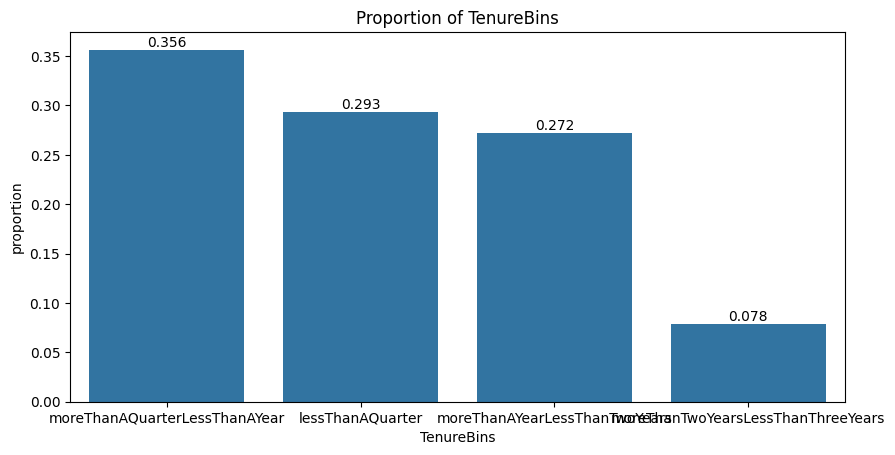

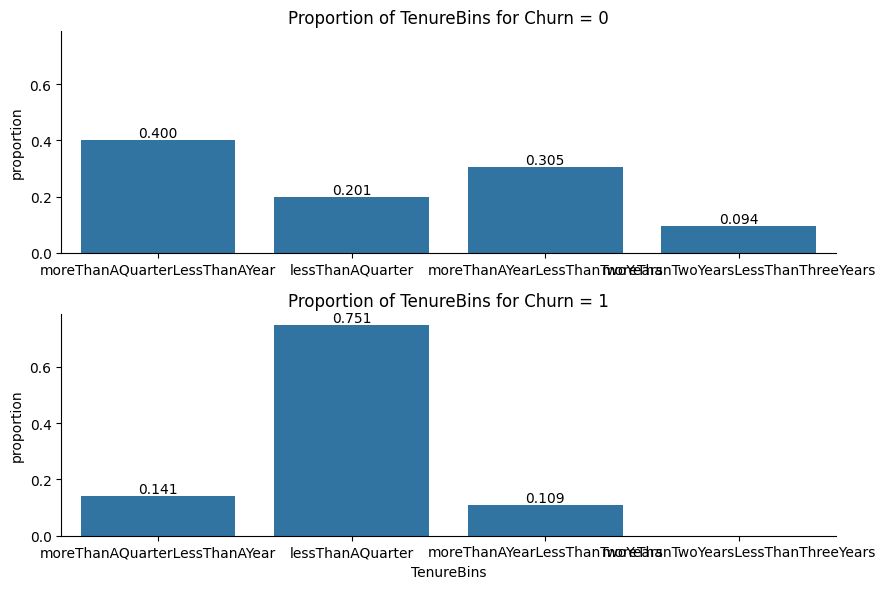

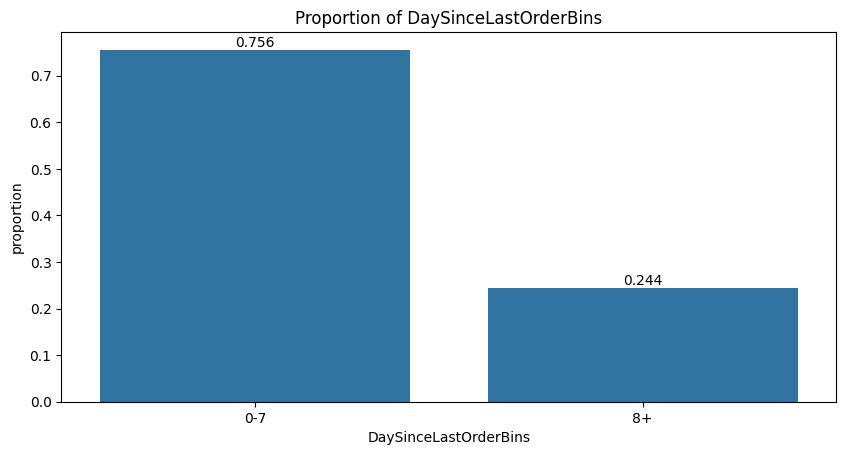

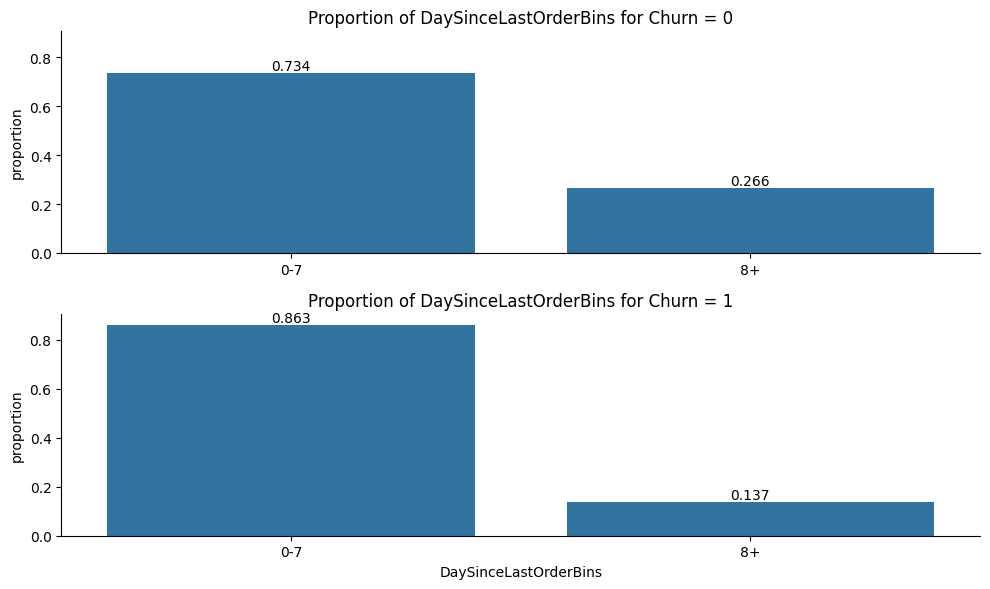

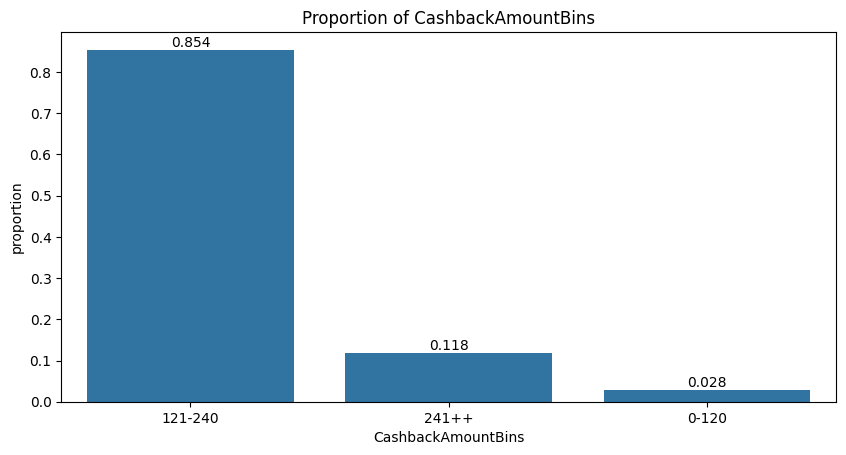

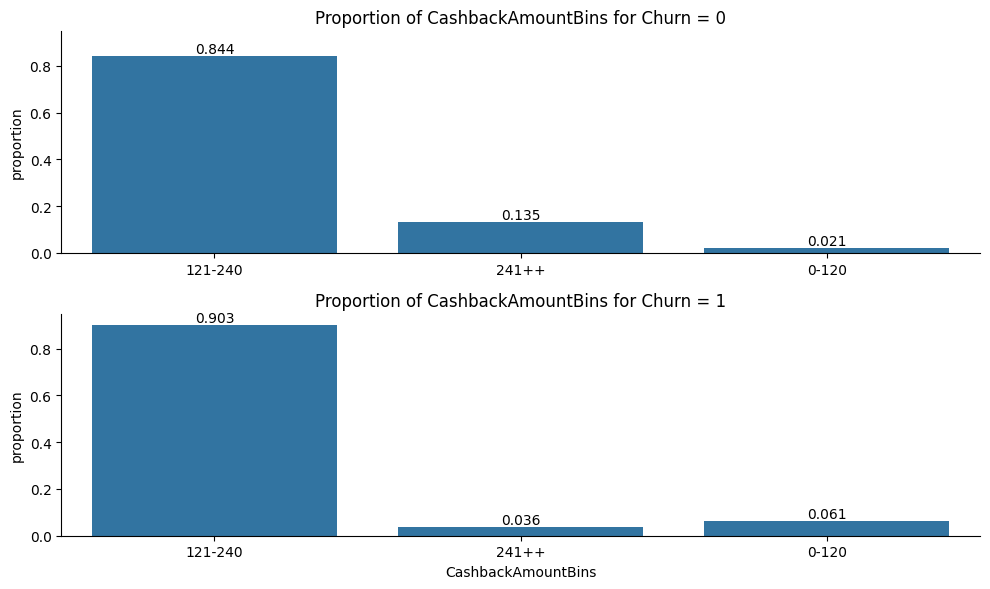

In [34]:
countplot_analysis(dfFinalFE, 'TenureBins')
countplot_analysis(dfFinalFE, 'DaySinceLastOrderBins')
countplot_analysis(dfFinalFE, 'CashbackAmountBins')

<h3>Hyperparameter tuning</h3>
<ol>
    <li>Improve each individual model by performing grid search first
    <li>Use best params to fit into each individual model and place these models into VotingClassifier
</ol>

In [35]:
# Default models
rf = RandomForestClassifier(random_state = 42)
xgb = XGBClassifier(random_state = 42)
lgbm = LGBMClassifier(random_state = 42, verbosity = -1)
votingClfr = VotingClassifier([('xgb', xgb), ('rf', rf), ('lgbm', lgbm)], 
                              n_jobs = 10, voting = 'soft')

rfParams = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],      
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

xgbParams = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'n_estimators': [100, 200, 500],
    'scale_pos_weight': [1, 2, 5]
}

lgbmParams = {
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [2, 5]
}

rfCV = tuneHyperparam(rf, rfParams, X_trainFE, y_trainFE)
xgbCV = tuneHyperparam(xgb, xgbParams, X_trainFE, y_trainFE)
lgbmCV = tuneHyperparam(lgbm, lgbmParams, X_trainFE, y_trainFE)

# Improved models
new_rf = RandomForestClassifier(random_state = 42)
new_rf.set_params(**rfCV.best_params_)
new_xgb = XGBClassifier(random_state = 42)
new_xgb.set_params(**xgbCV.best_params_)
new_lgbm = LGBMClassifier(random_state = 42)
new_lgbm.set_params(**lgbmCV.best_params_)
new_votingClfr = VotingClassifier([('xgb', new_xgb), ('rf', new_rf), ('lgbm', new_lgbm)], 
                              n_jobs = 10, voting = 'soft')


<h2>Overview of results</h2>

<h3>Evaluation on training data via cross validation within each model across categories</h3>

In [36]:
print('results for RF over time:\n', 
    pd.DataFrame(
        {
            'DefaultNoFE': test_models_v2(X_train, y_train, rf),
            'DefaultFE':test_models_v2(X_trainFE, y_trainFE, rf),
            'OptimisedNoFE': test_models_v2(X_train, y_train, new_rf),
            'OptimisedFE': test_models_v2(X_trainFE, y_trainFE, new_rf),
        }
    )
)
print('\n')

print('results for XGBoost over time:\n', 
    pd.DataFrame(
        {
            'DefaultNoFE': test_models_v2(X_train, y_train, xgb),
            'DefaultFE':test_models_v2(X_trainFE, y_trainFE, xgb),
            'OptimisedNoFE': test_models_v2(X_train, y_train, new_xgb),
            'OptimisedFE': test_models_v2(X_trainFE, y_trainFE, new_xgb),
        }
    )
)
print('\n')

print('results for LightGBM over time:\n', 
    pd.DataFrame(
        {
            'DefaultNoFE': test_models_v2(X_train, y_train, lgbm),
            'DefaultFE':test_models_v2(X_trainFE, y_trainFE, lgbm),
            'OptimisedNoFE': test_models_v2(X_train, y_train, new_lgbm),
            'OptimisedFE': test_models_v2(X_trainFE, y_trainFE, new_lgbm),
        }
    )
)
print('\n')

print('results for VotingClassifier over time:\n', 
    pd.DataFrame(
        {
            'DefaultNoFE': test_models_v2(X_train, y_train, votingClfr),
            'DefaultFE':test_models_v2(X_trainFE, y_trainFE, votingClfr),
            'OptimisedNoFE': test_models_v2(X_train, y_train, new_votingClfr),
            'OptimisedFE': test_models_v2(X_trainFE, y_trainFE, new_votingClfr),
        }
    )
)

results for RF over time:
            DefaultNoFE  DefaultFE  OptimisedNoFE  OptimisedFE
accuracy         94.94      94.56          95.96        96.06
recall           75.09      73.42          80.67        81.88
precision        93.76      92.79          94.62        94.00
f1               83.28      81.95          87.00        87.48


results for XGBoost over time:
            DefaultNoFE  DefaultFE  OptimisedNoFE  OptimisedFE
accuracy         94.84      95.40          95.50        95.86
recall           79.76      82.33          86.41        86.86
precision        88.56      89.55          86.84        88.37
f1               83.85      85.75          86.60        87.59


results for LightGBM over time:
            DefaultNoFE  DefaultFE  OptimisedNoFE  OptimisedFE
accuracy         94.94      94.87          96.03        96.31
recall           79.01      79.16          83.99        85.35
precision        89.82      89.14          91.78        92.16
f1               84.00      83.83   

<h3>Evaluation on training data via cross validation within each model across categories</h3>

In [37]:
print('results for default models without feature engineering:\n', 
    pd.DataFrame(
        {
            'RF': test_models_v2(X_train, y_train, rf),
            'XGBoost':test_models_v2(X_train, y_train, xgb),
            'LightGBM': test_models_v2(X_train, y_train, lgbm),
            'VotingClassifier': test_models_v2(X_train, y_train, votingClfr)
        }
    )
)
print('\n')

print('results for optimised models without feature engineering:\n', 
    pd.DataFrame(
        {
            'RF': test_models_v2(X_train, y_train, new_rf),
            'XGBoost':test_models_v2(X_train, y_train, new_xgb),
            'LightGBM': test_models_v2(X_train, y_train, new_lgbm),
            'VotingClassifier': test_models_v2(X_train, y_train, new_votingClfr)
        }
    )
)
print('\n')

print('results for default models with feature engineering:\n', 
    pd.DataFrame(
        {
            'RF': test_models_v2(X_trainFE, y_trainFE, rf),
            'XGBoost':test_models_v2(X_trainFE, y_trainFE, xgb),
            'LightGBM': test_models_v2(X_trainFE, y_trainFE, lgbm),
            'VotingClassifier': test_models_v2(X_trainFE, y_trainFE, votingClfr)
        }
    )
)
print('\n')

print('results for optimised models with feature engineering:\n', 
    pd.DataFrame(
        {
            'RF': test_models_v2(X_trainFE, y_trainFE, new_rf),
            'XGBoost':test_models_v2(X_trainFE, y_trainFE, new_xgb),
            'LightGBM': test_models_v2(X_trainFE, y_trainFE, new_lgbm),
            'VotingClassifier': test_models_v2(X_trainFE, y_trainFE, new_votingClfr)
        }
    )
)

results for default models without feature engineering:
               RF  XGBoost  LightGBM  VotingClassifier
accuracy   94.94    94.84     94.94             95.22
recall     75.09    79.76     79.01             79.76
precision  93.76    88.56     89.82             90.91
f1         83.28    83.85     84.00             84.88


results for optimised models without feature engineering:
               RF  XGBoost  LightGBM  VotingClassifier
accuracy   95.96    95.50     96.03             96.24
recall     80.67    86.41     83.99             84.60
precision  94.62    86.84     91.78             92.45
f1         87.00    86.60     87.69             88.32


results for default models with feature engineering:
               RF  XGBoost  LightGBM  VotingClassifier
accuracy   94.56    95.40     94.87             95.63
recall     73.42    82.33     79.16             80.97
precision  92.79    89.55     89.14             92.14
f1         81.95    85.75     83.83             86.16


results for op

<h3>Evaluation on test data prediction within each model across categories</h3>

In [38]:
print('results for RF over time:\n', 
    pd.DataFrame(
        {
            'DefaultNoFE': evalModelPredictions(rf, X_train, X_test, y_train, y_test),
            'DefaultFE':evalModelPredictions(rf, X_trainFE, X_testFE, y_trainFE, y_testFE),
            'OptimisedNoFE': evalModelPredictions(new_rf, X_train, X_test, y_train, y_test),
            'OptimisedFE': evalModelPredictions(new_rf, X_trainFE, X_testFE, y_trainFE, y_testFE)
        }
    )
)
print('\n')

print('results for XGBoost over time:\n', 
    pd.DataFrame(
        {
            'DefaultNoFE': evalModelPredictions(xgb, X_train, X_test, y_train, y_test),
            'DefaultFE':evalModelPredictions(xgb, X_trainFE, X_testFE, y_trainFE, y_testFE),
            'OptimisedNoFE': evalModelPredictions(new_xgb, X_train, X_test, y_train, y_test),
            'OptimisedFE': evalModelPredictions(new_xgb, X_trainFE, X_testFE, y_trainFE, y_testFE)
        }
    )
)
print('\n')

print('results for LightGBM over time:\n', 
    pd.DataFrame(
        {
            'DefaultNoFE': evalModelPredictions(lgbm, X_train, X_test, y_train, y_test),
            'DefaultFE':evalModelPredictions(lgbm, X_trainFE, X_testFE, y_trainFE, y_testFE),
            'OptimisedNoFE': evalModelPredictions(new_lgbm, X_train, X_test, y_train, y_test),
            'OptimisedFE': evalModelPredictions(new_lgbm, X_trainFE, X_testFE, y_trainFE, y_testFE)
        }
    )
)
print('\n')

print('results for VotingClassifier over time:\n', 
    pd.DataFrame(
        {
            'DefaultNoFE': evalModelPredictions(votingClfr, X_train, X_test, y_train, y_test),
            'DefaultFE':evalModelPredictions(votingClfr, X_trainFE, X_testFE, y_trainFE, y_testFE),
            'OptimisedNoFE': evalModelPredictions(new_votingClfr, X_train, X_test, y_train, y_test),
            'OptimisedFE': evalModelPredictions(new_votingClfr, X_trainFE, X_testFE, y_trainFE, y_testFE)
        }
    )
)

results for RF over time:
            DefaultNoFE  DefaultFE  OptimisedNoFE  OptimisedFE
accuracy         95.26      94.90          96.62        96.03
recall           78.87      77.82          86.27        86.62
precision        91.80      90.57          93.16        89.45
f1               84.85      83.71          89.58        88.01


results for XGBoost over time:
            DefaultNoFE  DefaultFE  OptimisedNoFE  OptimisedFE
accuracy         95.73      95.49          95.97        95.91
recall           84.51      83.45          88.38        88.73
precision        89.55      89.10          87.76        87.20
f1               86.96      86.18          88.07        87.96


results for LightGBM over time:
            DefaultNoFE  DefaultFE  OptimisedNoFE  OptimisedFE
accuracy         94.96      95.43          96.20        96.09
recall           80.63      82.75          87.68        87.68
precision        88.42      89.35          89.57        88.93
f1               84.35      85.92   

<h3>Evaluation on test data prediction within each category across models</h3>

In [39]:
print('results for default models without feature engineering:\n', 
    pd.DataFrame(
        {
            'RF': evalModelPredictions(rf, X_train, X_test, y_train, y_test),
            'XGBoost':evalModelPredictions(xgb, X_train, X_test, y_train, y_test),
            'LightGBM': evalModelPredictions(lgbm, X_train, X_test, y_train, y_test),
            'VotingClassifier': evalModelPredictions(votingClfr, X_train, X_test, y_train, y_test)
        }
    )
)
print('\n')

print('results for optimised models without feature engineering:\n', 
    pd.DataFrame(
        {
            'RF': evalModelPredictions(new_rf, X_train, X_test, y_train, y_test),
            'XGBoost':evalModelPredictions(new_xgb, X_train, X_test, y_train, y_test),
            'LightGBM': evalModelPredictions(new_lgbm, X_train, X_test, y_train, y_test),
            'VotingClassifier': evalModelPredictions(new_votingClfr, X_train, X_test, y_train, y_test)
        }
    )
)
print('\n')

print('results for default models with feature engineering:\n', 
    pd.DataFrame(
        {
            'RF': evalModelPredictions(rf, X_trainFE, X_testFE, y_trainFE, y_testFE),
            'XGBoost':evalModelPredictions(xgb, X_trainFE, X_testFE, y_trainFE, y_testFE),
            'LightGBM': evalModelPredictions(lgbm, X_trainFE, X_testFE, y_trainFE, y_testFE),
            'VotingClassifier': evalModelPredictions(votingClfr, X_trainFE, X_testFE, y_trainFE, y_testFE)
        }
    )
)
print('\n')

print('results for optimised models with feature engineering:\n', 
    pd.DataFrame(
        {
            'RF': evalModelPredictions(new_rf, X_trainFE, X_testFE, y_trainFE, y_testFE),
            'XGBoost':evalModelPredictions(new_xgb, X_trainFE, X_testFE, y_trainFE, y_testFE),
            'LightGBM': evalModelPredictions(new_lgbm, X_trainFE, X_testFE, y_trainFE, y_testFE),
            'VotingClassifier': evalModelPredictions(new_votingClfr, X_trainFE, X_testFE, y_trainFE, y_testFE)
        }
    )
)

results for default models without feature engineering:
               RF  XGBoost  LightGBM  VotingClassifier
accuracy   95.26    95.73     94.96             95.61
recall     78.87    84.51     80.63             83.10
precision  91.80    89.55     88.42             90.08
f1         84.85    86.96     84.35             86.45


results for optimised models without feature engineering:
               RF  XGBoost  LightGBM  VotingClassifier
accuracy   96.62    95.97     96.20             96.44
recall     86.27    88.38     87.68             89.08
precision  93.16    87.76     89.57             89.72
f1         89.58    88.07     88.61             89.40


results for default models with feature engineering:
               RF  XGBoost  LightGBM  VotingClassifier
accuracy   94.90    95.49     95.43             95.73
recall     77.82    83.45     82.75             84.15
precision  90.57    89.10     89.35             89.85
f1         83.71    86.18     85.92             86.91


results for op

<h2>Conclusion</h2>
<ul>
    <li>RF performed best, VotingClassifier has slightly poorer performance.</li>
    <li>When making predictions with test data, feature engineering turned out to cause the models to perform worse in general, could be signs of overfitting.</li>
    <li>Hyperparameter tuning was the key contributer to model improvement from base model</li>
</ul>

<h3>Best performing model is optimised RF without feature engineering with f1-score of 89.58%</h3>

<h3>Key takeaways</h3>
<ul>
    <li>More iterations of trial and error required to obtain meaningful features</li>
</ul>